# Data Analysis

- Data subsection selection
- Outlier dectection
    - z-scores
- Data Scaling (mean 0 std 1)
- Dimension reduction
    - PCA (% explained variance) 
    - Truncated SVD
    - Lasso 
- Clustering
    - K-Means
    - Gaussian Mixture Models (GMM)
    - HDBSCAN Cluster
    - Hierarchical clustering (different distance metrics)
- Plotting:
    - PCA
    - t-SNE
    - UMap
    - (Stress Calculation)
- Histograms
    - clusters 
    - mutant groups    
- Retrive specific cluster (a cell cycle stage)
    - filter out the wild type
    - plots by mutant group

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Importing the data

In [2]:
raw_df = pd.read_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/patches3_rmsprop_features.csv')

### Add label (wild type or mutant) and group columns to Data Frame

In [3]:
# 1 for mutant 0 for wild type
raw_df['label'] = raw_df['image_path'].apply(lambda x: 1 if 'mutant' in x.lower() else 0)

In [4]:
# Function to extract group number using regex
def extract_batch(path):
    basename = os.path.basename(path)
    directory = os.path.dirname(path)
    return int(basename.split()[0][:-3])

def extract_group(path):
    basename = os.path.basename(path)
    directory = os.path.dirname(path)
    group = ''
    if "mutants" in directory:
        group = basename.split()[3]
    else:
        group = basename.split()[2]
    
    return int(group)

# Apply the function to add a new column
raw_df['batch'] = raw_df['image_path'].apply(extract_batch)
raw_df['group'] = raw_df['image_path'].apply(extract_group)

# Move Image_Path to the end of the DF
first_column = raw_df.iloc[:, 0].name  # Get the name of the first column
raw_df = raw_df[[col for col in raw_df.columns if col != first_column] + [first_column]]

In [5]:
raw_df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,label,batch,group,image_path
0,-0.000015,0.000041,0.000361,-0.000913,0.001696,0.000002,-0.001157,-0.044952,-0.00002,-0.000027,...,0.011581,0.000905,-0.004547,0.000018,-0.000253,-0.001631,1,190423,3,/scratch/leuven/359/vsc35907/feature_extractio...
1,-0.000015,0.000041,0.000361,-0.000927,0.001696,0.000002,-0.001158,-0.042516,-0.00002,-0.000027,...,0.011581,0.000905,-0.004547,0.000172,-0.000253,-0.001631,1,190423,4,/scratch/leuven/359/vsc35907/feature_extractio...


In [6]:
raw_df.shape

(26600, 1284)

#### Removing columns with only one unique value

In [7]:
count = 0
column_names = []
for i in range(1280):
    if len(raw_df[f'feature_{i}'].unique()) == 1:
        column_names.append(f'feature_{i}')
        count += 1
        
#print(column_names)
print(f"Total columns with only one unique value: {count}")

Total columns with only one unique value: 158


In [8]:
raw_df = raw_df.drop(columns=column_names, inplace=False)

In [9]:
raw_df.shape

(26600, 1126)

## Outlier Detection

In [10]:
def filter_outliers_zscore(df, threshold=3):
    # Calculate z-scores
    z_scores = np.abs((df - df.mean()) / df.std())
    
    # Create mask for inliers (where all z-scores are below threshold)
    inlier_mask = (z_scores < threshold).all(axis=1)
    
    # Return both filtered DataFrame and outliers DataFrame
    df_cleaned = df[inlier_mask]
    df_outliers = df[~inlier_mask]
    
    return df_cleaned, df_outliers

In [11]:
features = raw_df.columns[:-4]
df, df_outliers = filter_outliers_zscore(raw_df[features], 5)

In [12]:
outlier_indices = df_outliers.index
inlier_indices = df.index

# Add back the columns to df_outliers
df_outliers['image_path'] = raw_df.loc[outlier_indices, 'image_path']
df_outliers['label'] = raw_df.loc[outlier_indices, 'label']
df_outliers['batch'] = raw_df.loc[outlier_indices, 'batch']
df_outliers['group'] = raw_df.loc[outlier_indices, 'group']

# Add back the columns to df
df['image_path'] = raw_df.loc[inlier_indices, 'image_path']
df['label'] = raw_df.loc[inlier_indices, 'label']
df['batch'] = raw_df.loc[inlier_indices, 'batch']
df['group'] = raw_df.loc[inlier_indices, 'group']

df now has the path label and group at the last 3 columns

In [13]:
df.shape

(24468, 1126)

In [14]:
df_outliers.shape # (has image_path column)

(2132, 1126)

__Saves outliers in a folder (optional)__

In [17]:
import shutil

outliers_dir = '/scratch/leuven/359/vsc35907/feature_extraction_data/analysis/outliers'
os.makedirs(outliers_dir, exist_ok=True)

outliers = df_outliers.image_path.tolist()
for img in outliers:
    basename = os.path.basename(img)
    dst_file = os.path.join(outliers_dir, basename)
    shutil.copy2(img, dst_file)

To inspect localy:

``
scp “vsc35907@login.hpc.kuleuven.be:/scratch/leuven/359/vsc35907/feature_extraction_data/analysis/outliers/*” /Users/theo/Desktop/outliers
``

### Data Subsection selection

__Specify a subsection of the data to analyse__

#### Select only the mutants:

In [8]:
df = df[df['label'] == 1].copy()

#### Select only the wild type:

In [15]:
df = df[df['label'] == 0].copy()

#### Select only a specific group (mutant group or wild type group):

In [16]:
df.batch.unique()

array([190423, 190425, 181213, 190421])

In [15]:
df = df[(df['label'] == 0) & (df['batch'] == 181213) & (df['group'] == 3)].copy()

In [15]:
df = df[(df['label'] == 0) & (df['batch'] == 181213)].copy()

In [16]:
df.head(2)

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,...,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,image_path,label,batch,group
13300,0.000041,-0.001096,0.001697,0.000002,-0.001091,-0.024068,-0.000027,0.002695,-0.000018,0.000822,...,0.011581,0.000912,-0.004547,0.002047,-0.000253,-0.001631,/scratch/leuven/359/vsc35907/feature_extractio...,0,181213,2
13301,0.000041,-0.001122,0.001697,0.000002,-0.001083,-0.020974,-0.000027,0.002695,-0.000018,0.000822,...,0.011581,0.000913,-0.004547,0.002328,-0.000253,-0.001631,/scratch/leuven/359/vsc35907/feature_extractio...,0,181213,3


In [17]:
df.shape

(9569, 1126)

## Data Scalling 

Standardize features by removing the mean and scaling to unit variance. (i.e. set mean to be zero and std to 1)

z = (x - u) / s

In [18]:
from sklearn.preprocessing import StandardScaler

feature_columns = df.columns[:-4]

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[feature_columns])

Robust Scaller (does not really works)

In [6]:
# from sklearn.preprocessing import RobustScaler

# feature_columns = df.columns[:-4]

# # Robustly scale features
# scaler = RobustScaler()
# data_scaled = scaler.fit_transform(df[feature_columns])

## Batch Correction 
Uses data_scaled

In [11]:
feature_columns = df.columns[:1280]

# Wild-type features and batch information
wt_features = wild_type_df[feature_columns]
wt_batches = wild_type_df['group']

### Combat

In [12]:
from combat.pycombat import pycombat

data_scaled = pycombat(
    data=wt_features.T,  # ComBat expects features as rows, samples as columns
    batch=wt_batches
).T # Transpose back to original shape

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/combat/pycombat.py:158: RuntimeWarning: invalid value encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(
/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


### Linear Method

In [13]:
from sklearn.linear_model import LinearRegression

# Initialize corrected features
wt_features_corrected = wt_features.copy()

# Regress out batch effect for each feature
for col in feature_columns:
    # Create batch dummy variables
    batch_dummies = pd.get_dummies(wt_batches, drop_first=True)
    # Fit linear model
    model = LinearRegression()
    model.fit(batch_dummies, wt_features[col])
    # Subtract batch effect
    batch_effect = model.predict(batch_dummies)
    wt_features_corrected[col] = wt_features[col] - batch_effect

In [14]:
data_scaled = wt_features_corrected

In [15]:
data_scaled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
13300,-1.694066e-21,6.776264e-21,0.0,0.000007,-6.543073e-09,1.935056e-12,-2.324081e-06,-0.000787,0.0,2.271715e-13,...,0.007595,6.160356e-12,-3.388132e-21,1.355253e-20,8.592205e-09,-2.623497e-07,1.309577e-11,-0.000074,-8.908781e-15,1.839644e-10
13301,-1.694066e-21,6.776264e-21,0.0,-0.000015,1.381707e-08,-3.430671e-12,5.191972e-06,0.001722,0.0,5.168934e-13,...,-0.016315,-5.192190e-11,-3.388132e-21,1.355253e-20,-1.865380e-08,5.829548e-07,1.491882e-11,0.000163,-2.896008e-13,-2.609917e-10
13302,-1.694066e-21,3.820762e-12,0.0,0.000039,1.361533e-07,-8.680072e-11,-3.235294e-05,-0.002102,0.0,-1.442234e-12,...,-0.073378,-1.020347e-09,1.898504e-12,1.355253e-20,8.822382e-08,-3.028305e-06,-1.839272e-10,-0.000434,1.449638e-11,9.790066e-10
13303,-1.694066e-21,-1.179238e-12,0.0,-0.000073,-1.804672e-08,3.029928e-11,3.528616e-05,0.007215,0.0,5.577665e-13,...,-0.041242,3.796529e-10,-1.014962e-13,1.355253e-20,-1.097762e-07,3.653345e-06,7.160728e-10,0.000814,-5.503625e-12,-1.420993e-09
13304,-1.694066e-21,6.776264e-21,0.0,0.000035,-3.578293e-08,9.569329e-12,-1.198043e-05,-0.004112,0.0,-3.483107e-12,...,0.041773,1.280781e-10,-3.388132e-21,1.355253e-20,4.434620e-08,-1.355205e-06,1.491882e-11,-0.000386,-2.896008e-13,7.390083e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26595,-1.694066e-21,3.820762e-12,0.0,0.000067,1.045328e-08,-2.450072e-11,-3.159634e-05,-0.006675,0.0,-1.442234e-12,...,0.037789,-3.203471e-10,-1.014962e-13,1.355253e-20,1.002238e-07,-3.287335e-06,-6.839272e-10,-0.000744,1.449638e-11,1.379007e-09
26596,-1.694066e-21,6.776264e-21,0.0,0.000003,-6.908897e-09,2.805321e-12,-7.586912e-07,-0.000443,0.0,2.468382e-13,...,0.005449,3.504579e-11,-3.388132e-21,1.355253e-20,3.674662e-09,-9.912928e-08,1.094636e-11,-0.000037,-5.233325e-14,-9.712167e-11
26597,-1.694066e-21,6.776264e-21,0.0,-0.000018,1.165693e-08,-9.649443e-13,7.076619e-06,0.002057,0.0,2.271715e-13,...,-0.018292,6.160356e-12,-3.388132e-21,1.355253e-20,-2.340780e-08,7.741103e-07,1.309577e-11,0.000203,-8.908781e-15,-3.160356e-10
26598,-1.694066e-21,6.776264e-21,0.0,0.000044,-3.908293e-08,8.769329e-12,-1.561803e-05,-0.005078,0.0,-3.483107e-12,...,0.049702,6.807810e-11,-3.388132e-21,1.355253e-20,5.634620e-08,-1.745785e-06,1.491882e-11,-0.000484,-2.896008e-13,8.390083e-10


## Dimension Reduction 
Uses data_scaled

### PCA (X% variance)

In [19]:
from sklearn.decomposition import PCA

# 2. Initialize PCA to retain X% of the variance
pca = PCA(n_components=0.90)

# 3. Fit PCA and transform features
reduced_data = pca.fit_transform(data_scaled)

# 4. Create a new DataFrame from the reduced data
df_reduced = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# 5. add back 'label' and 'group' columns
df_reduced['label'] = df['label'].values
df_reduced['batch'] = df['batch'].values
df_reduced['group'] = df['group'].values

In [20]:
df_reduced.shape

(9569, 7)

### Truncated SVD

In [20]:
from sklearn.decomposition import TruncatedSVD

# 2. Initialize TruncatedSVD 
svd = TruncatedSVD(n_components=4)

# 3. Fit TruncatedSVD and transform features
reduced_data = svd.fit_transform(data_scaled)
# reduced_data = svd.fit_transform(df.iloc[:, 1:-2])

# 4. Create a new DataFrame from the reduced data
df_reduced = pd.DataFrame(reduced_data, columns=[f'SVD{i+1}' for i in range(reduced_data.shape[1])])

# 5. add back 'label' and 'group' columns
df_reduced['label'] = df['label'].values
df_reduced['batch'] = df['batch'].values
df_reduced['group'] = df['group'].values

Explained Variance

In [21]:
svd.explained_variance_ratio_
sum(svd.explained_variance_ratio_)

0.9086055236114068

In [22]:
df_reduced.shape

(2241, 6)

### Lasso

In [18]:
from sklearn.linear_model import Lasso

# 2. Initialize Lasso with alpha parameter (controls regularization strength)
lasso = Lasso(alpha=0.05)  # Adjust alpha as needed: smaller values = less regularization

# 3. Fit Lasso and select non-zero features
# Assuming data_scaled has labels in df['label']
X = data_scaled
y = df['label'].values
lasso.fit(X, y)

# Get features with non-zero coefficients
selected_features = np.where(lasso.coef_ != 0)[0]
reduced_data = X[:, selected_features]

# 4. Create a new DataFrame from the reduced data
# Using original feature names if available, otherwise generic names
if hasattr(data_scaled, 'columns'):
    feature_names = data_scaled.columns[selected_features]
else:
    feature_names = [f'variable{i+1}' for i in range(len(selected_features))]
df_reduced = pd.DataFrame(reduced_data, columns=feature_names)

# 5. Add back 'label' and 'group' columns
df_reduced['label'] = df['label'].values
df_reduced['batch'] = df['batch'].values
df_reduced['group'] = df['group'].values

/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


In [19]:
df_reduced.shape

(2241, 2)

## Clustering 
Uses df_reduced

### K Means

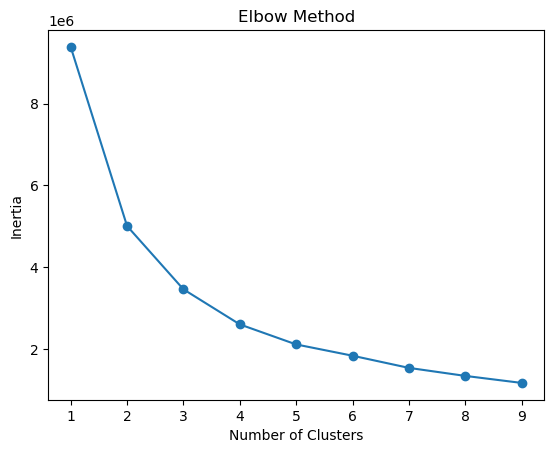

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_reduced.iloc[:, :-2])
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [22]:
# Apply K-Means with optimal k value
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['k-means'] = kmeans.fit_predict(df_reduced.iloc[:, :-2])

### Gaussian Mixture Models (GMM)

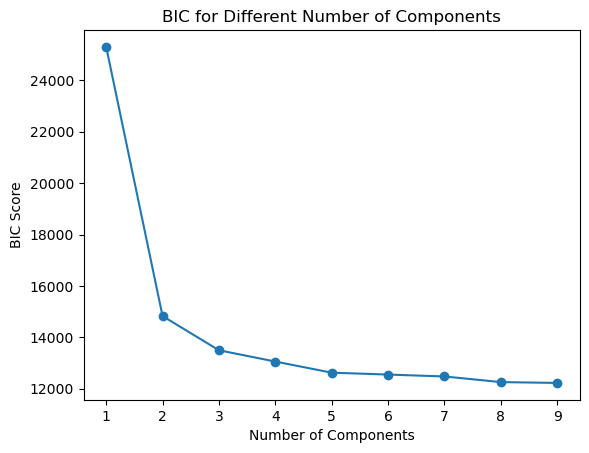

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

n_components_range = range(1, 10)  # Adjust range as needed
bic = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_reduced.iloc[:, :-2])
    bic.append(gmm.bic(df_reduced.iloc[:, :-2]))

# Plot BIC to choose number of components
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC for Different Number of Components')
plt.show()

In [23]:
from sklearn.mixture import GaussianMixture

optimal_n = 3

gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(df_reduced.iloc[:, :-2])

labels = gmm.predict(df_reduced.iloc[:, :-2])
probs = gmm.predict_proba(df_reduced.iloc[:, :-2])

# Add cluster labels to your original DataFrame
df['gaussian'] = labels

### HDBSCAN

In [37]:
import hdbscan
import warnings

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    df['HDBSCAN'] = clusterer.fit_predict(df_reduced.iloc[:, :-3])

### Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linked = linkage(df_reduced.iloc[:, :-2], method='ward', metric='euclidean')  # 'ward' minimizes variance

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Cut the dendrogram to form clusters 
hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
# hierarchical = AgglomerativeClustering(n_clusters=6, metric='correlation', linkage='complete')
# hierarchical = AgglomerativeClustering(n_clusters=4, metric='correlation', linkage='average')
# hierarchical = AgglomerativeClustering(n_clusters=6, metric='cosine', linkage='average')

df['hierarchical_cluster'] = hierarchical.fit_predict(df_reduced.iloc[:, :-2])

## Topological Data Analysis

In [46]:
import giddy
import networkx as nx

# Step 1: Preprocess the data
X = df.drop(columns=['label', 'group', 'image_path']).values  # Feature matrix
y = df['label'].values  # Labels
groups = df['group'].values  # Groups

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply Mapper
# Use PCA as a filter function to project data (you can also use labels or other features)
pca = PCA(n_components=2)
filter_func = pca.fit_transform(X_scaled)

# Configure Mapper
mapper = giddy.Mapper(
    filter_function=filter_func,
    cover=giddy.CubicalCover(n_intervals=10, overlap_frac=0.3),
    clusterer=giddy.KMeans(n_clusters=5)
)

# Fit Mapper and get the graph
mapper_graph = mapper.fit_transform(X_scaled)

# Step 3: Analyze the Mapper graph (using networkx)
nx_graph = mapper_graph  # Mapper returns a networkx-compatible graph

# Basic topological properties
print("Number of nodes:", nx_graph.number_of_nodes())
print("Number of edges:", nx_graph.number_of_edges())
components = list(nx.connected_components(nx_graph))
print("Connected components:", len(components))

# Step 4: Visualize the graph
# Color nodes by average label (mutant vs. wild_type)
node_labels = {}
for node, data in nx_graph.nodes(data=True):
    indices = data['indices']  # Indices of points in this node
    node_labels[node] = np.mean(y[indices])  # Mean label (0 to 1)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(nx_graph)
nx.draw(
    nx_graph, pos, node_color=list(node_labels.values()), cmap='viridis',
    node_size=300, with_labels=False
)
plt.colorbar(label='Mean Label (0=Wild Type, 1=Mutant)')
plt.title("Mapper Graph of Feature Space")
plt.show()

AttributeError: module 'giddy' has no attribute 'Mapper'

## Plotting Visualization
Uses data_scaled

### PCA

In [23]:
from sklearn.decomposition import PCA

# Reduce dimensions with PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

In [24]:
import matplotlib.pyplot as plt

def pca_plot(cluster_type):
    plt.figure(figsize=(8, 6))

    for group in sorted(df[cluster_type].unique()):
        mask = (df[cluster_type] == group)
        plt.scatter(
            data_pca[mask, 0],
            data_pca[mask, 1],
            label=f'Cluster {group}',
            s=10
        )

    plt.title(f'PCA Plot by {cluster_type}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.savefig(f'./plots/pca_plot_{cluster_type}.png')
    plt.show()

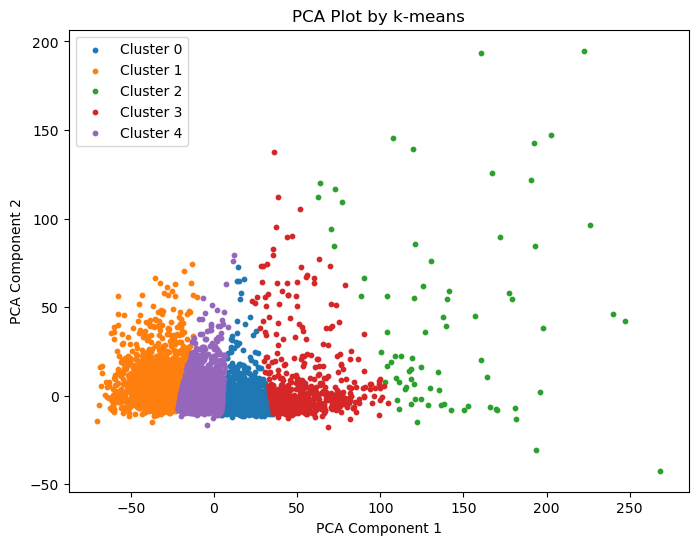

In [25]:
pca_plot('k-means')

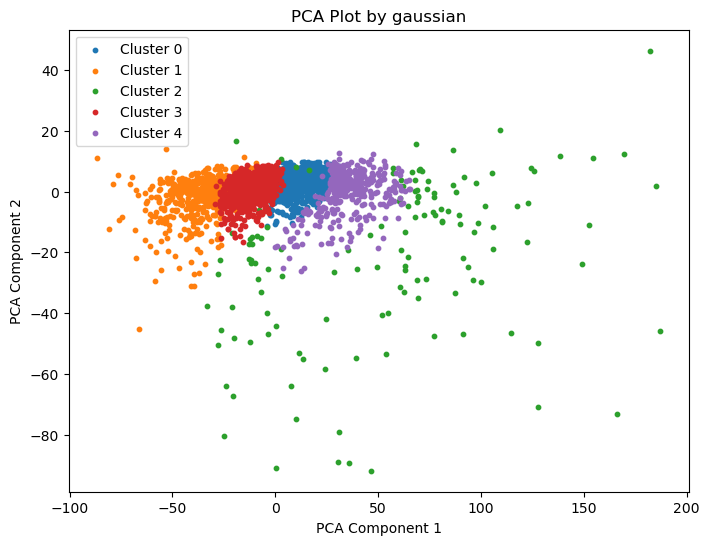

In [35]:
pca_plot('gaussian')

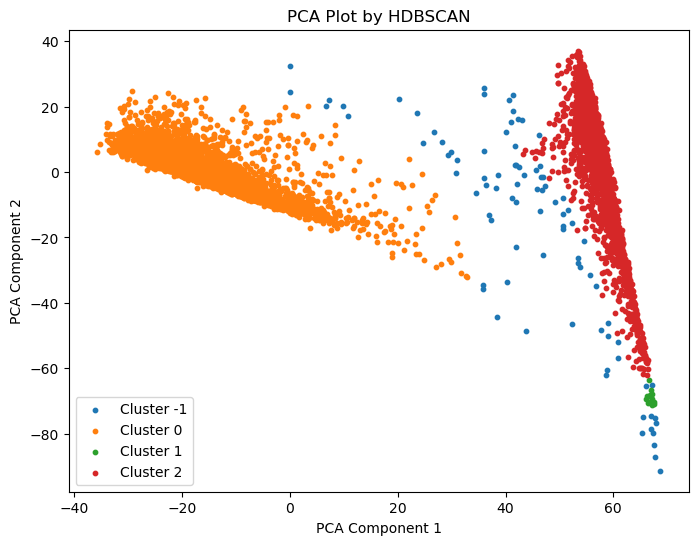

In [22]:
pca_plot('HDBSCAN')

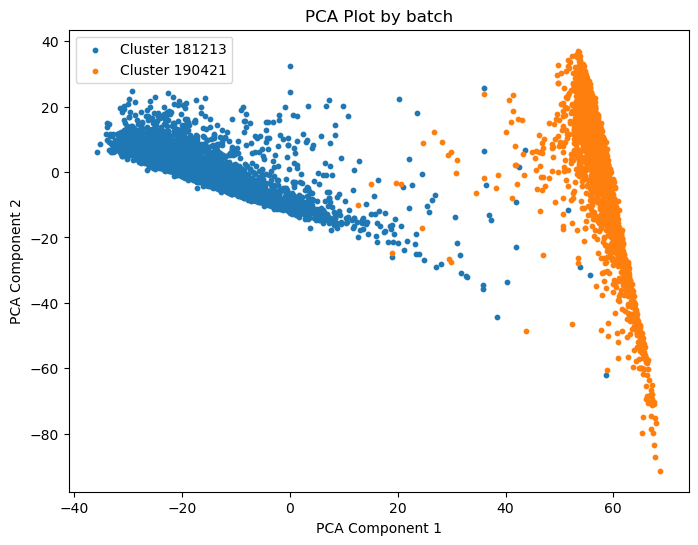

In [23]:
pca_plot('batch')

In [ ]:
pca_plot('hierarchical_cluster')

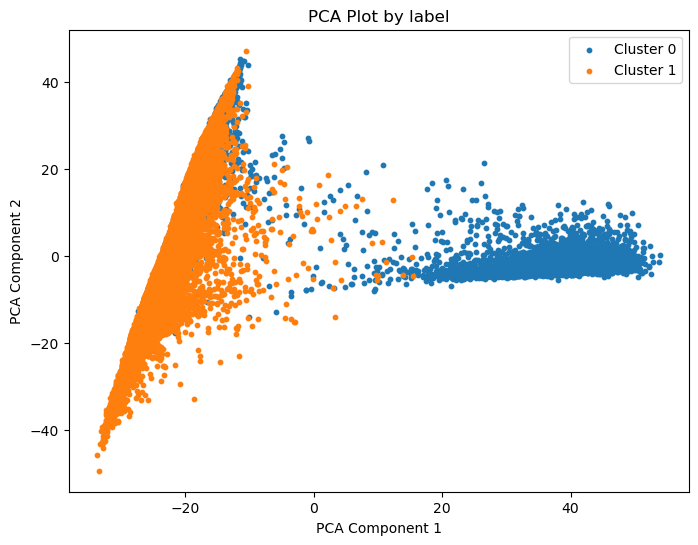

In [29]:
pca_plot('label')

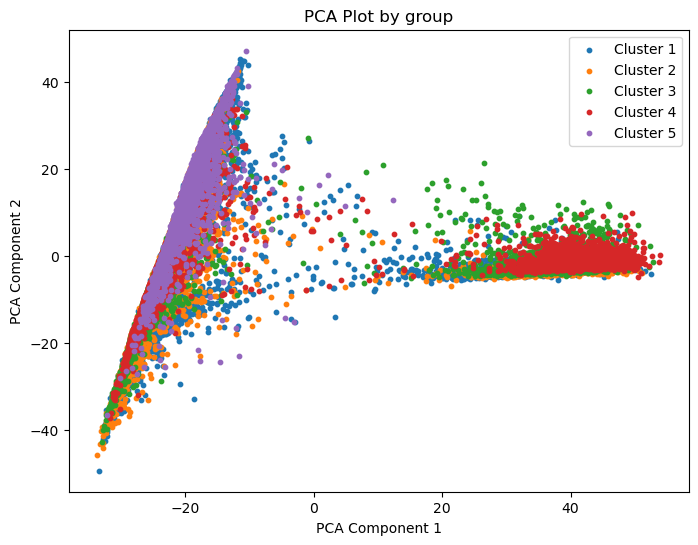

In [30]:
pca_plot('group')

### t-SNE

In [26]:
from sklearn.manifold import TSNE

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

In [27]:
import matplotlib.pyplot as plt

def tsne_plot(cluster_type):
    plt.figure(figsize=(8, 6))

    for group in sorted(df[cluster_type].unique()):
        mask = (df[cluster_type] == group)
        plt.scatter(
            data_tsne[mask, 0],
            data_tsne[mask, 1],
            label=f'Cluster {group}',
            s=20
        )

    plt.title('t-SNE Plot by Label')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.savefig(f'./plots/tsne_plot_{cluster_type}.png')
    plt.show()

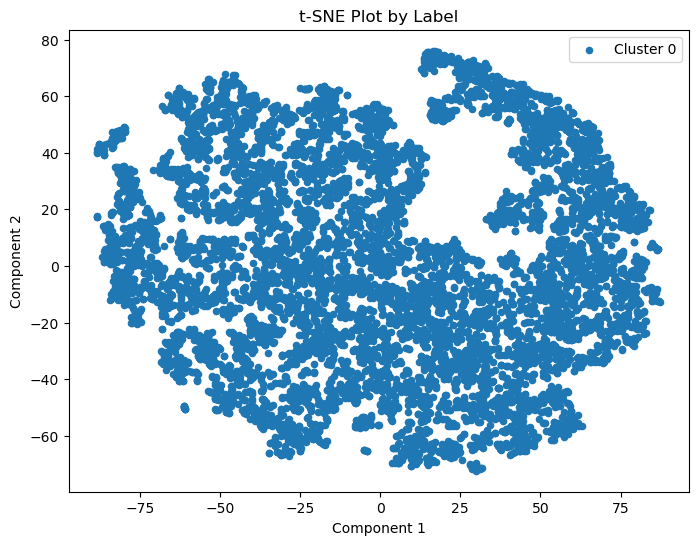

In [28]:
tsne_plot('label')

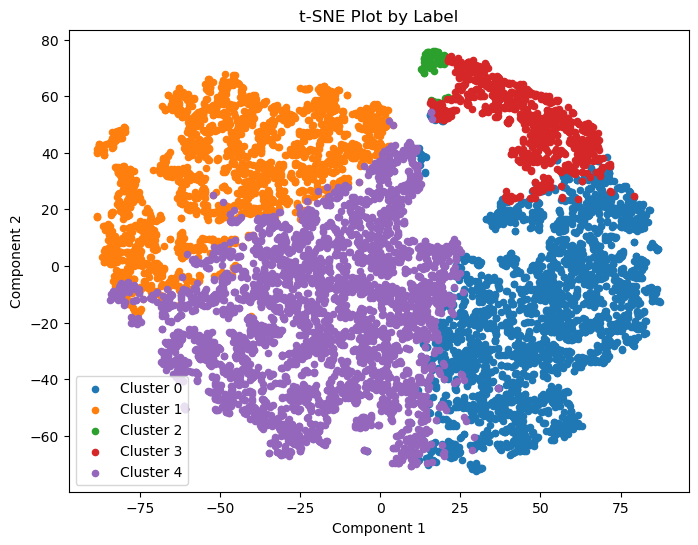

In [29]:
tsne_plot('k-means')

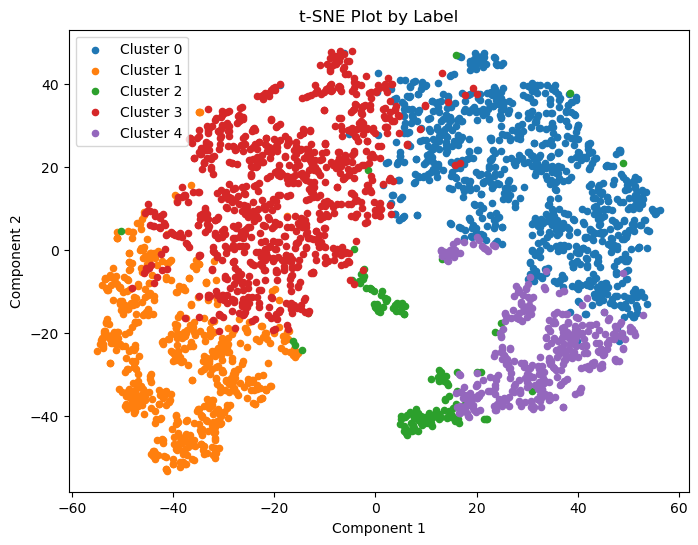

In [43]:
tsne_plot('gaussian')

In [ ]:
tsne_plot('hierarchical_cluster')

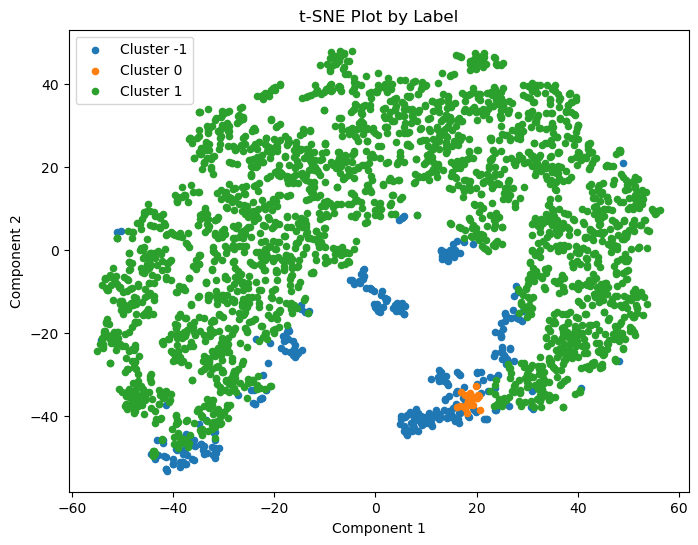

In [45]:
tsne_plot('HDBSCAN')

### UMAP

In [30]:
import warnings

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    
    import umap

    # Apply UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    data_umap = umap_reducer.fit_transform(data_scaled)

In [31]:
import matplotlib.pyplot as plt

def umap_plot(cluster_type):
    plt.figure(figsize=(8, 6))

    for group in sorted(df[cluster_type].unique()):
        mask = (df[cluster_type] == group)
        plt.scatter(
            data_umap[mask, 0],
            data_umap[mask, 1],
            label=f'label {group}'
        )

    plt.title('UMAP Plot by Label')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.savefig(f'./plots/umap_plot_{cluster_type}.png')
    plt.show()

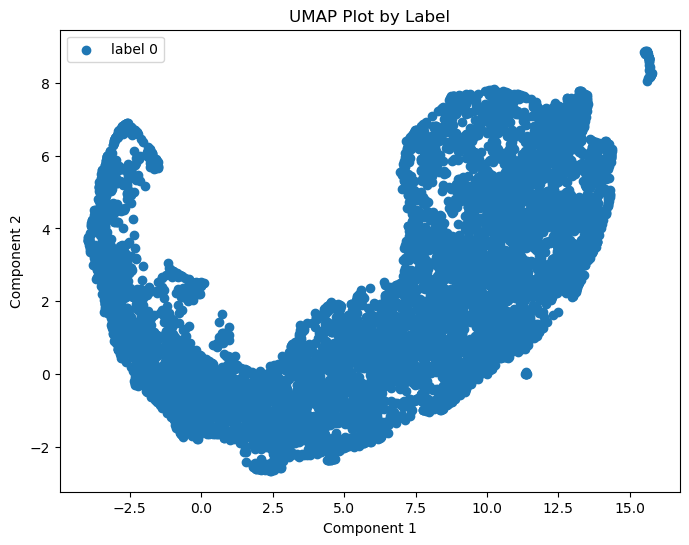

In [32]:
umap_plot('label')

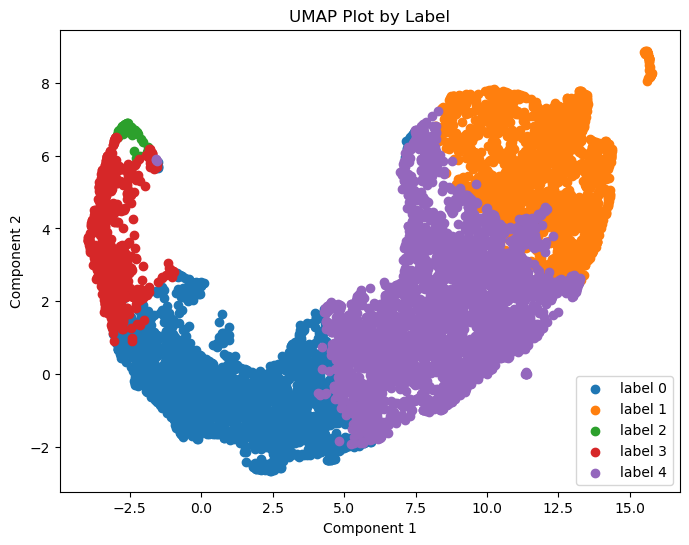

In [33]:
# wild type group 1
umap_plot('k-means')

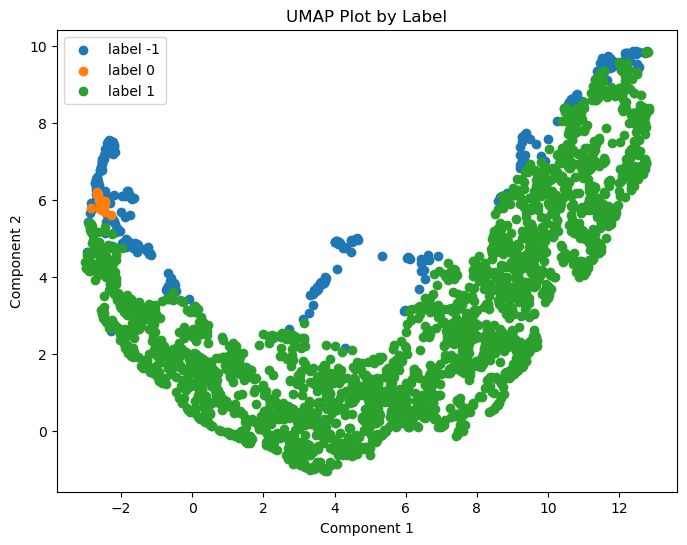

In [49]:
# wild type group 1
umap_plot('HDBSCAN')

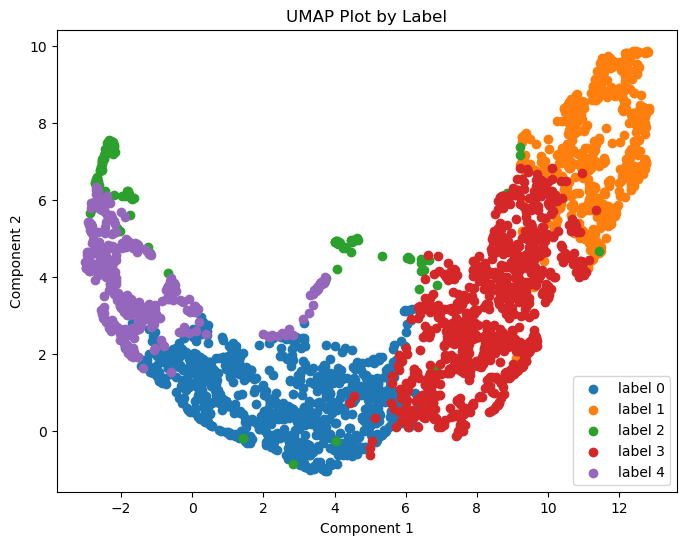

In [50]:
# wild type group 1
umap_plot('gaussian')

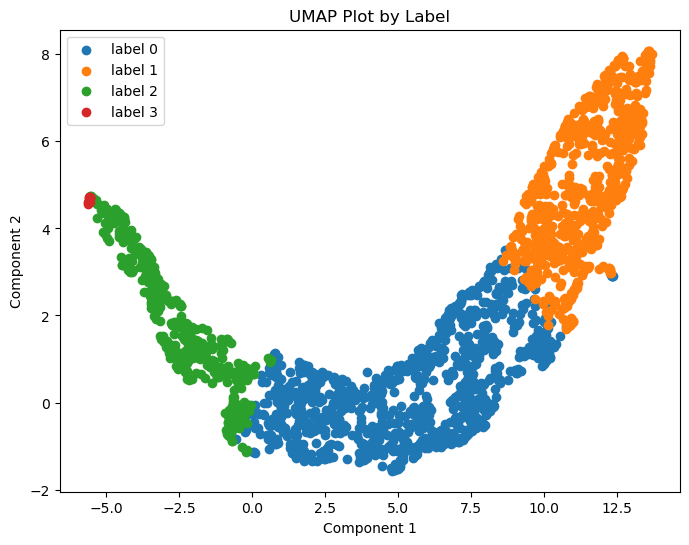

In [40]:
# wild type group 2
umap_plot('k-means')

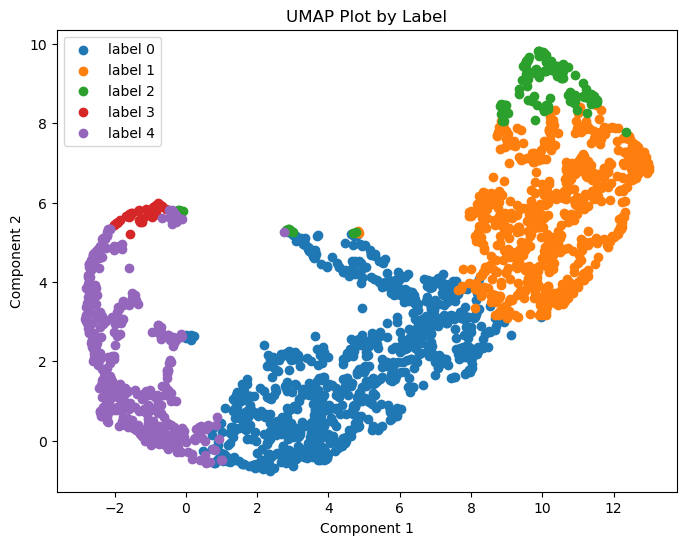

In [39]:
# Wild type group 3
umap_plot('k-means')

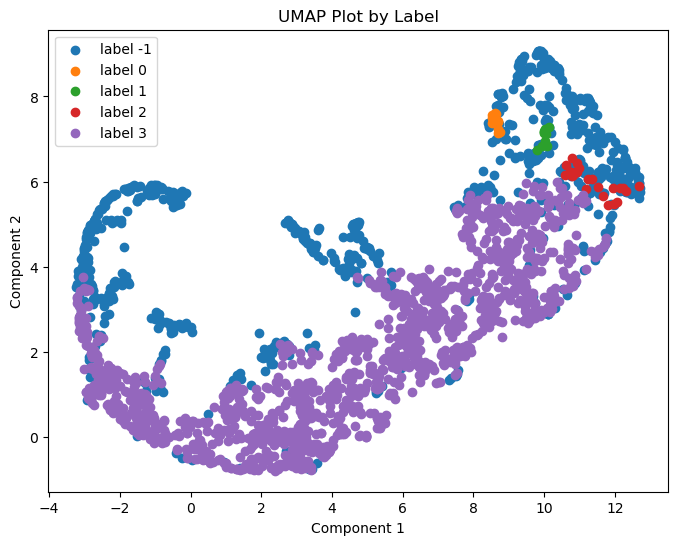

In [31]:
# Wild type group 3
umap_plot('HDBSCAN')

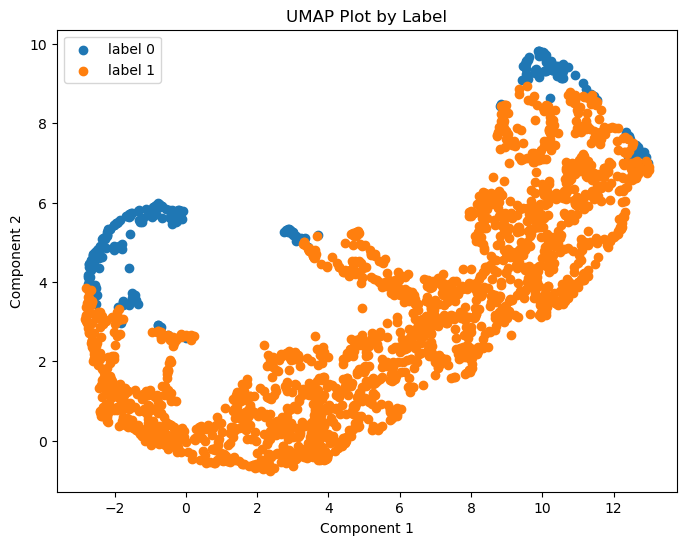

In [40]:
umap_plot('gaussian')

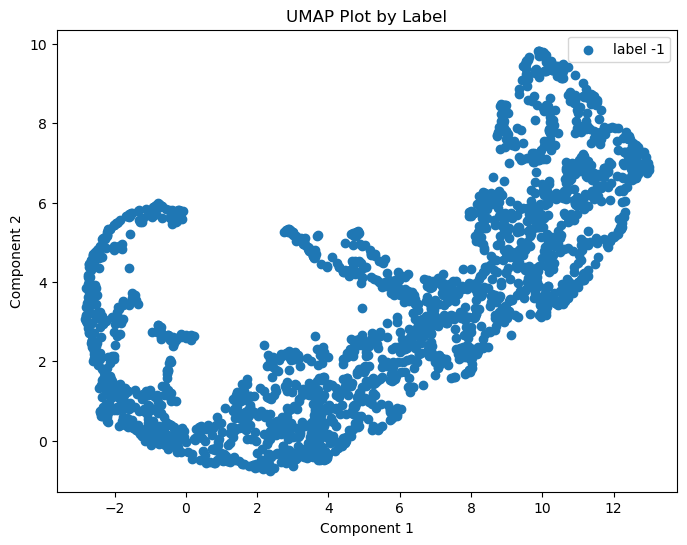

In [41]:
umap_plot('HDBSCAN')

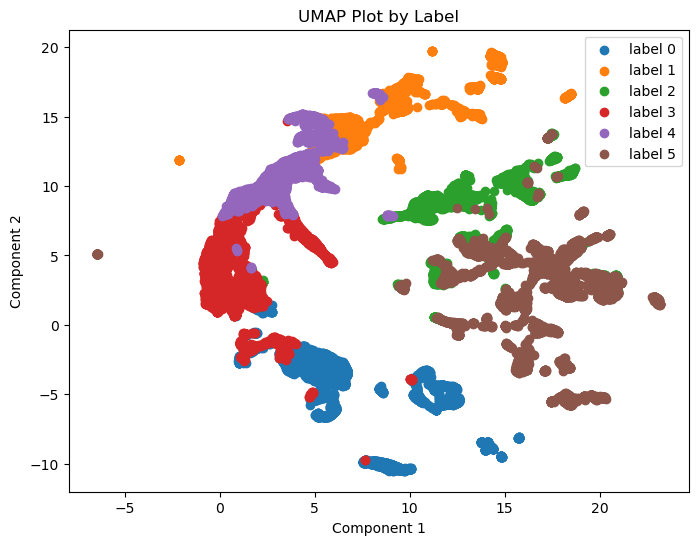

In [62]:
umap_plot('hierarchical_cluster')

### PHATE

In [34]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_scaled)

Calculating PHATE...
  Running PHATE on 9569 observations and 1122 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.20 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 5.18 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.94 seconds.
  Calculated landmark operator in 2.82 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 0.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.18 seconds.
Calculated PHATE in 12.04 seconds.


In [35]:
import matplotlib.pyplot as plt

def phate_plot(cluster_type):
    plt.figure(figsize=(8, 6))

    for group in sorted(df[cluster_type].unique()):
        mask = (df[cluster_type] == group)
        plt.scatter(
            data_phate[mask, 0],
            data_phate[mask, 1],
            label=f'label {group}'
        )

    plt.title(f'PHATE Plot by {cluster_type}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.savefig(f'./plots/phate_plot_{cluster_type}.png')
    plt.show()

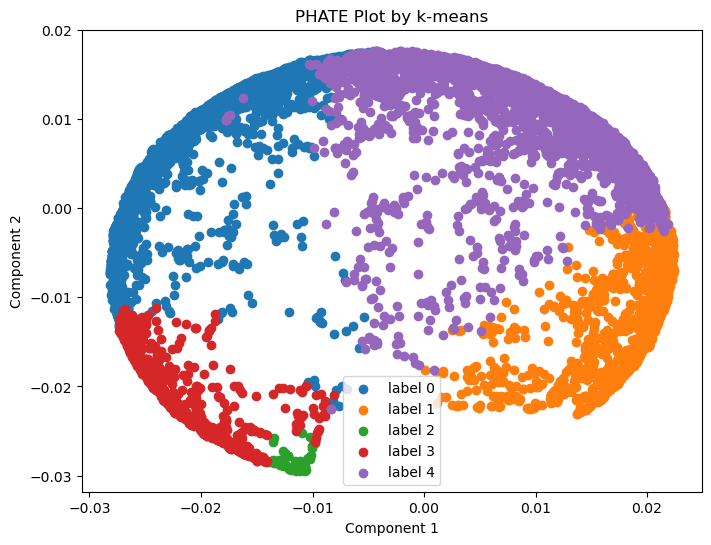

In [36]:
phate_plot('k-means')

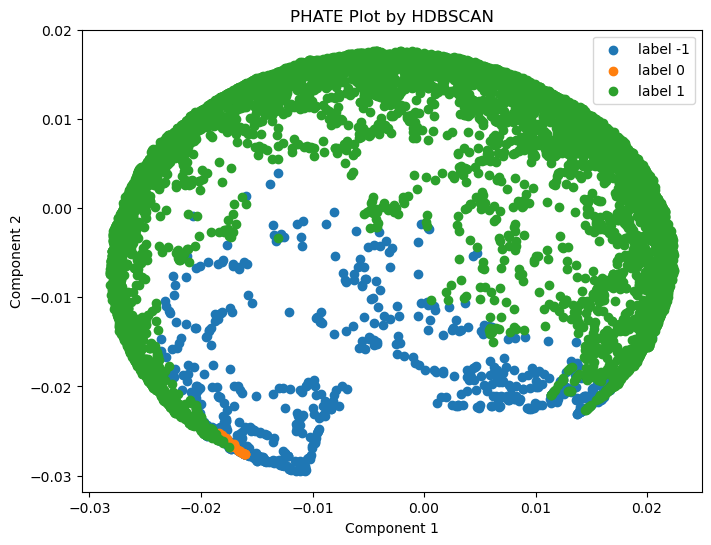

In [38]:
phate_plot('HDBSCAN')

## Pseudo Time Inference

Trajectory inference or pseudotemporal ordering is a computational technique used in single-cell transcriptomics to determine the pattern of a dynamic process experienced by cells and then arrange cells based on their progression through the process. 

__TODO:__ 
try different algorithms:
- Monocle
- Slingshot
- Diffusion Pseudotime (DPT)
- PAGA
- Palantir
- TSCAN
- SCORPIUS

In [39]:
data_phate.shape

(9569, 2)

In [43]:
center_x = -0.02
center_y = -0.025
half_side_length = 0.0005  # Example side length of the square

# Retrieve points inside the square perimeter
indices = np.where(
    (data_phate[:, 0] >= center_x - half_side_length) & 
    (data_phate[:, 0] <= center_x + half_side_length) & 
    (data_phate[:, 1] >= center_y - half_side_length) & 
    (data_phate[:, 1] <= center_y + half_side_length)
)

# Print the points inside the square
print(indices)

(array([ 359,  484,  863, 1169, 2431, 2747, 3756, 4846, 4957, 4986, 5144,
       5802, 6369, 6405, 6667, 7307, 7369, 8212, 8503, 8518, 8921, 9285,
       9441]),)


In [44]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

# Build kNN graph (sparse adjacency matrix)
knn_graph = kneighbors_graph(data_phate, n_neighbors=10, mode='distance', include_self=False)

# Choose a root cell
root_index = 863

# Compute shortest path distances from root
geodesic_distances = shortest_path(knn_graph, directed=False, indices=root_index)

# Normalize to [0, 1] pseudotime
pseudotime = (geodesic_distances - geodesic_distances.min()) / (geodesic_distances.max() - geodesic_distances.min())

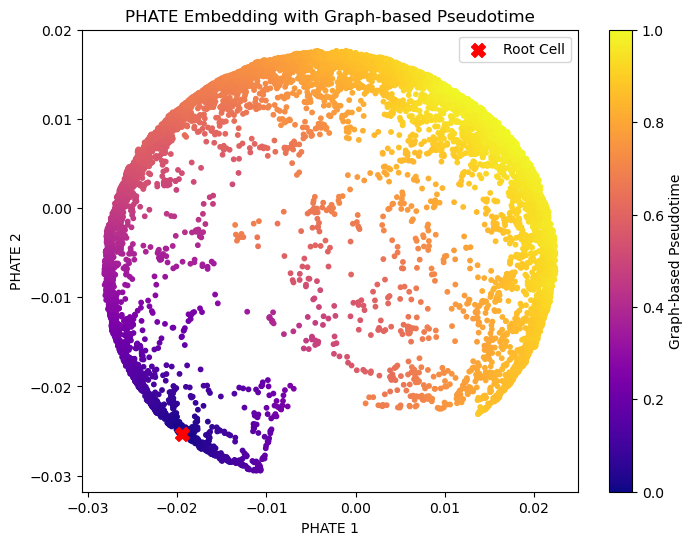

In [45]:
import matplotlib.pyplot as plt

# Plot the PHATE embedding with pseudotime coloring
plt.figure(figsize=(8,6))
plt.scatter(data_phate[:,0], data_phate[:,1], c=pseudotime, cmap='plasma', s=10)
plt.colorbar(label='Graph-based Pseudotime')

# Highlight the root cell with an 'X' marker
plt.scatter(data_phate[root_index, 0], data_phate[root_index, 1], color='red', marker='X', s=100, label='Root Cell')

# Title and labels
plt.title('PHATE Embedding with Graph-based Pseudotime')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')

# Optional: Add a legend to label the root cell
plt.legend()

# Show the plot
plt.show()

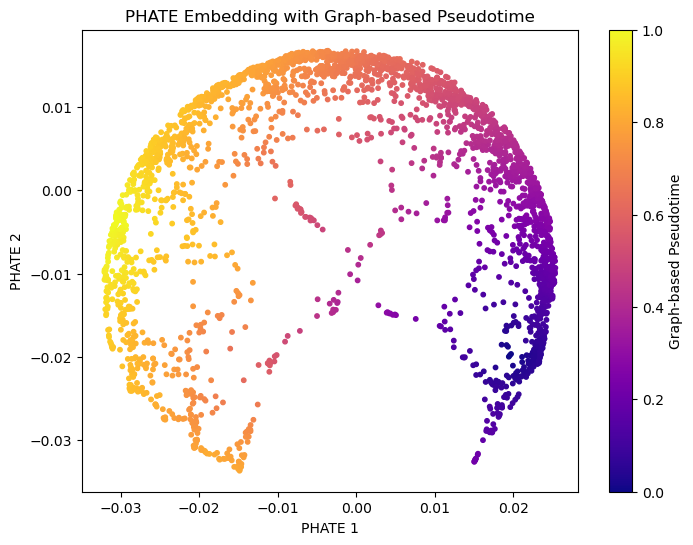

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(data_phate[:,0], data_phate[:,1], c=pseudotime, cmap='plasma', s=10)
plt.colorbar(label='Graph-based Pseudotime')
plt.title('PHATE Embedding with Graph-based Pseudotime')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.show()

In [39]:
df.head(1)

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,...,feature_1277,feature_1278,feature_1279,image_path,label,batch,group,k-means,gaussian,HDBSCAN
13303,0.000041,-0.001089,0.001697,0.000002,-0.001095,-0.024796,-0.000027,0.002695,-0.000018,0.000822,...,0.001966,-0.000253,-0.001631,/scratch/leuven/359/vsc35907/feature_extractio...,0,181213,1,0,1,-1


In [48]:
import scanpy as sc

# Convert to Scaled Data into AnnData
adata = sc.AnnData(data_scaled)
adata.obs_names = [str(i) for i in range(data_scaled.shape[0])]
adata.var_names = [f"feature_{i}" for i in range(data_scaled.shape[1])]

In [50]:
adata

AnnData object with n_obs × n_vars = 2873 × 1122
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
# Compute neighbors using PCA
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

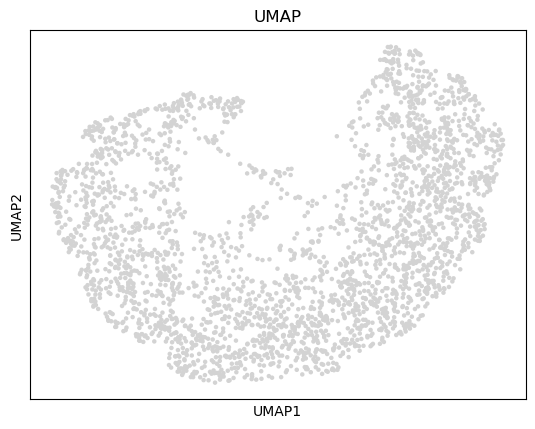

In [56]:
# Embed in UMAP space
sc.tl.umap(adata)

# Plot UMAP
sc.pl.umap(adata, title='UMAP')

In [52]:
# 5. Compute Diffusion Map
sc.tl.diffmap(adata)

In [42]:
# 6. Choose a root cell (you can adjust based on your UMAP/checkmark)
# Example: pick the cell with minimum PC1 value as a rough start
root_index = np.argmin(adata.obsm['X_pca'][:, 0])

# 7. Compute Pseudotime
sc.tl.dpt(adata, n_dcs=10, root=root_index)

# 8. Add results back to your original DataFrame
df["pseudotime"] = adata.obs["dpt_pseudotime"].values

# Optional: Save pseudotime values
#df.to_csv("embeddings_with_pseudotime.csv")

ValueError: Length of passed value for obs_names is 2873, but this AnnData has shape: (2869, 1129)

In [ ]:
sc.pl.embedding(adata, basis="phate", color=["label", "dpt_pseudotime"], cmap="viridis")

### Stress Calculation

In [77]:
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import pairwise_distances

# Function to calculate stress
def calculate_stress(orig_dist, embedded_dist):
    return np.sqrt(np.sum((orig_dist - embedded_dist)**2)) / np.sqrt(np.sum(orig_dist**2))

# Function to create Shepard diagram
def plot_shepard_diagram(ax, original_distances, embedded_distances, method_name):
    # Flatten the distance matrices
    orig_dist_flat = original_distances[np.triu_indices(original_distances.shape[0], k=1)]
    emb_dist_flat = embedded_distances[np.triu_indices(embedded_distances.shape[0], k=1)]

    # Calculate stress
    stress = calculate_stress(orig_dist_flat, emb_dist_flat)

    # Calculate Spearman correlation
    correlation, _ = spearmanr(orig_dist_flat, emb_dist_flat)

    # Create scatter plot
    ax.scatter(orig_dist_flat, emb_dist_flat, alpha=0.5, s=20)

    # Add perfect correlation line
    min_dist = min(orig_dist_flat.min(), emb_dist_flat.min())
    max_dist = max(orig_dist_flat.max(), emb_dist_flat.max())
    ax.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', alpha=0.8)

    ax.set_xlabel('Original Distances')
    ax.set_ylabel('Embedded Distances')
    ax.set_title(f'{method_name}\nStress: {stress:.3f}, Correlation: {correlation:.3f}')

In [ ]:
# Features and labels
labels = df['label']  # Second column contains labels (species)

# Unique species and colors
unique_classes = labels.unique()
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_classes)))

# Original pairwise distances
original_distances = pairwise_distances(data_scaled)

# Dimensionality reduction methods
embeddings = {
    'PCA': data_pca,
    't-SNE': data_tsne,
    'UMAP': data_umap,
}

# Pairwise distances in embedding spaces
embedded_distances = {
    method: pairwise_distances(embedding)
    for method, embedding in embeddings.items()
}

In [ ]:
# Visualization
fig = plt.figure(figsize=(16, 8))
n_methods = len(embeddings)

for idx, (method, embedding) in enumerate(embeddings.items()):
    # Top row: Projection plot
    ax_proj = plt.subplot(2, n_methods, idx + 1)
    for i, species in enumerate(unique_species):
        species_mask = labels == species
        ax_proj.scatter(
            embedding[species_mask, 0],
            embedding[species_mask, 1],
            c=[colors[i]],
            label=species,
            s=50,
            alpha=0.7
        )
    ax_proj.set_title(method)
    if idx == 0:
        ax_proj.legend(title="K-Clusters", loc="center left", bbox_to_anchor=(1, 0.5))

    # Bottom row: Shepard diagram
    ax_shep = plt.subplot(2, n_methods, idx + n_methods + 1)
    plot_shepard_diagram(ax_shep, original_distances, embedded_distances[method], method)

# Print stress values
print("\nStress values:")
print("-" * 50)
for method, distances in embedded_distances.items():
    stress = calculate_stress(original_distances, distances)
    print(f"{method}: {stress:.3f}")

plt.tight_layout()
plt.show()

Some batch effect between group 1 and the rest of the wild types

## Clusters characterization

In [22]:
# Saving reference to main data frame
temp_df = df

In [82]:
df = temp_df

### selecting mutant cluster

In [83]:
# cluster_df = df[(df['label'] == 1) & (df['k-means'] == 1)]
# cluster_df = df[(df['label'] == 1) & (df['k-means'] == 2)]
# cluster_df = df[(df['label'] == 1) & (df['k-means'] == 3)]
cluster_df = df[(df['label'] == 1) & (df['k-means'] == 4)]
# cluster_df = df[(df['label'] == 1) & (df['k-means'] == 5)]
# cluster_df = df[(df['label'] == 1) & (df['k-means'] == 6)]

In [84]:
cluster_df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1276,feature_1277,feature_1278,feature_1279,image_path,label,group,k-means,gaussian,HDBSCAN
12,3.772924,0.0,32.843983,-0.000057,-1.135130e-13,-3.508439e-16,-0.000020,1.382685e+00,-4.751056e-31,-5.675069e-04,...,30.95607,0.309327,3.912335e+00,-2.076355e-35,/scratch/leuven/359/vsc35907/feature_extractio...,1,4,4,2,1
33,0.906867,0.0,34.396350,0.031831,-1.420889e-16,-2.430030e-15,-0.000002,-6.198005e-10,-9.198695e-35,-2.344230e-12,...,67.10102,0.218076,-2.606784e-15,0.000000e+00,/scratch/leuven/359/vsc35907/feature_extractio...,1,1,4,3,-1


### Filtering Outliers

In [85]:
def filter_outliers_zscore(df, threshold=3):
      
    # Identify columns with non-zero variance
    valid_columns = df.columns[df.std() != 0]
    
    if len(valid_columns) == 0:
        # If no columns have variance, return original df as cleaned, empty outliers
        return df, pd.DataFrame(columns=df.columns)
    
    # Calculate z-scores
    z_scores = np.abs((df[valid_columns] - df[valid_columns].mean()) / df[valid_columns].std())
    #print(z_scores)
    
    # Create mask for inliers (where all z-scores are below threshold)
    inlier_mask = (z_scores < threshold).all(axis=1)
    
    # Return both filtered DataFrame and outliers DataFrame
    df_cleaned = df[inlier_mask]
    df_outliers = df[~inlier_mask]
    
    return df_cleaned, df_outliers

In [86]:
# columns to ignore
n_col = 6

In [90]:
features = cluster_df.columns[:-n_col]
df, df_outliers = filter_outliers_zscore(cluster_df[features], 10)

outlier_indices = df_outliers.index
inlier_indices = df.index

# Add the image_path column to df_outliers
df_outliers['image_path'] = cluster_df.loc[outlier_indices, 'image_path']
df['image_path'] = cluster_df.loc[inlier_indices, 'image_path']
#df['label'] = cluster_df.loc[inlier_indices, 'label']
df['group'] = cluster_df.loc[inlier_indices, 'group']

In [91]:
df_outliers.shape

(162, 1281)

In [92]:
df.shape

(941, 1282)

In [93]:
df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,image_path,group
12,3.772924,0.0,32.843983,-0.000057,-1.135130e-13,-3.508439e-16,-0.000020,1.382685,-4.751056e-31,-5.675069e-04,...,0.0,15.406637,97.34772,-5.706515e-35,30.95607,0.309327,3.912335,-2.076355e-35,/scratch/leuven/359/vsc35907/feature_extractio...,4
35,8.195936,0.0,21.681074,0.285495,-3.024993e-10,-5.423846e-15,-0.000086,1.833018,-2.648682e-28,-9.759705e-07,...,0.0,19.893293,76.44460,-5.146177e-36,40.80846,0.760944,12.429164,-5.544794e-34,/scratch/leuven/359/vsc35907/feature_extractio...,2


### Data Scaling

In [94]:
# columns to ignore
n_col = 2

In [95]:
from sklearn.preprocessing import StandardScaler

feature_columns = df.columns[:-n_col]

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[feature_columns])

### PCA plot

In [96]:
from sklearn.decomposition import PCA

# Reduce dimensions with PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

In [97]:
import matplotlib.pyplot as plt

def pca_plot(cluster_type, df):
    plt.figure(figsize=(8, 6))

    for group in sorted(df[cluster_type].unique()):
        mask = (df[cluster_type] == group)
        plt.scatter(
            data_pca[mask, 0],
            data_pca[mask, 1],
            label=f'Mutant: {group}',
            s=10
        )

    plt.title(f'PCA Plot by {cluster_type}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.savefig(f'./plots/pca_plot_{cluster_type}.png')
    plt.show()

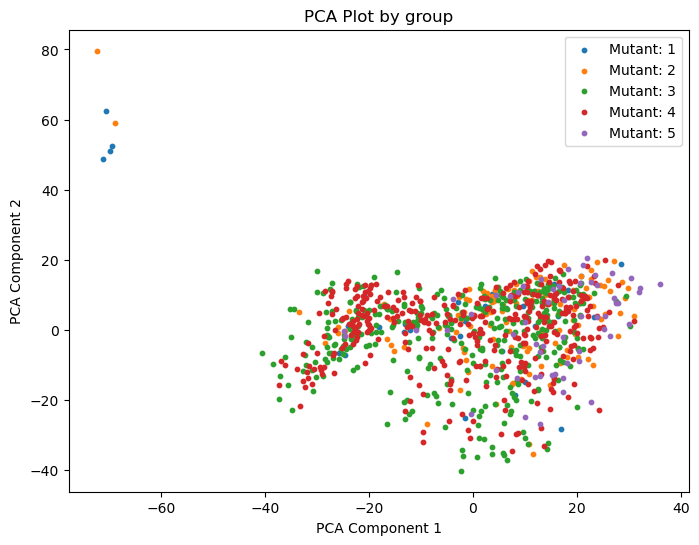

In [98]:
pca_plot('group', df)

In [31]:
from sklearn.decomposition import PCA

# Reduce dimensions with PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_pca_3d(df, data_pca, group):
    # Assuming `data_pca` has three components (PCA Component 1, 2, and 3)
    # Modify for 3D visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in range(k):
        ax.scatter(
            data_pca[df[group] == cluster, 0], 
            data_pca[df[group] == cluster, 1], 
            data_pca[df[group] == cluster, 2], 
            label=f'Cluster {cluster}'
        )

    # Add labels and title
    ax.set_title(f'3D K-Means Clusters (k={k})')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.savefig(f'plots/{group}_pca_3D_plot.png')
    plt.show()

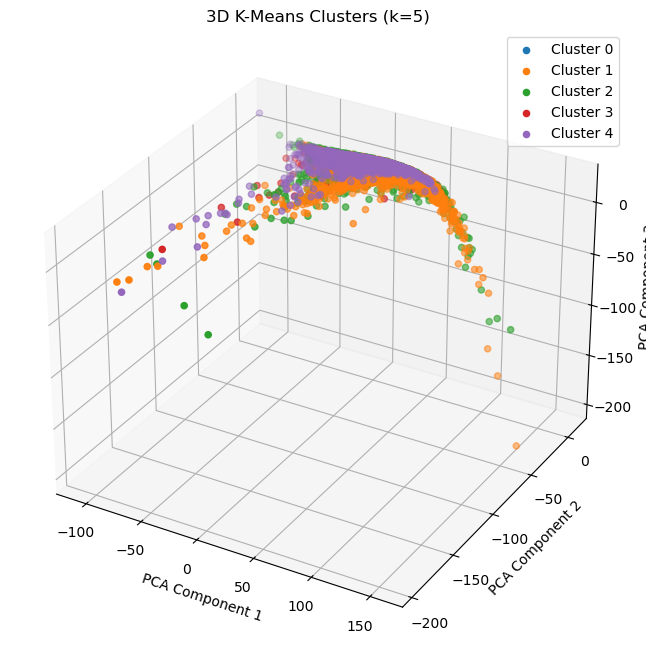

In [36]:
plot_pca_3d(df, data_pca, 'group')

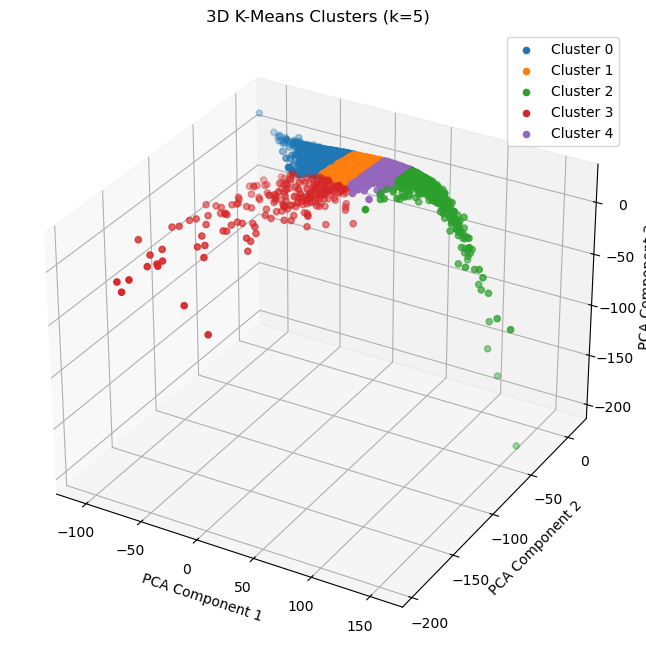

In [37]:
plot_pca_3d(df, data_pca, 'k-means')

/tmp/ipykernel_505942/1663961640.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', k)  # Choose a colormap with k colors


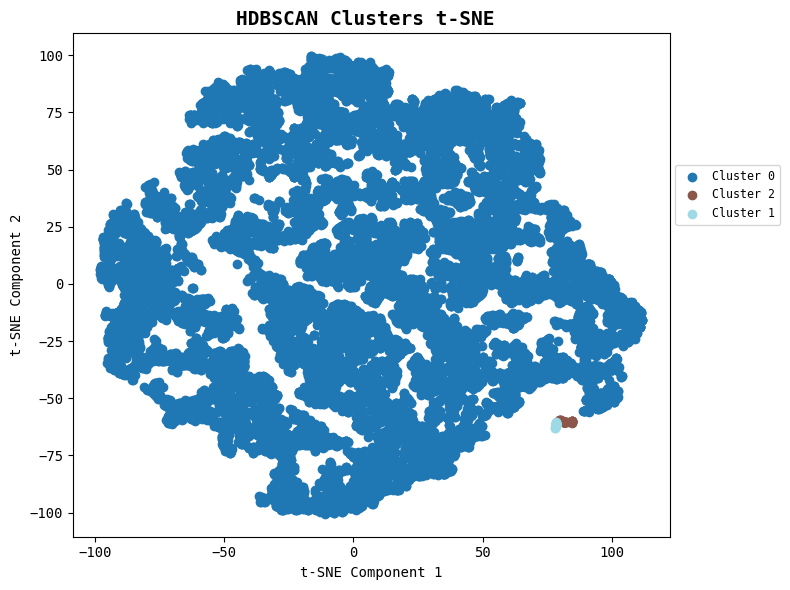

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Define the number of clusters and a colormap
unique_clusters = df['HDBSCAN'].unique()
unique_clusters = [cluster for cluster in unique_clusters if cluster != -1]
k = len(unique_clusters)
colormap = cm.get_cmap('tab20', k)  # Choose a colormap with k colors
# Set the font to monospace
plt.rc('font', family='monospace')

# Plot the clusters
plt.figure(figsize=(8, 6))
for idx, cluster in enumerate(unique_clusters):
    # Get the color from the colormap
    color = colormap(idx)
    cluster_mask = df['HDBSCAN'] == cluster
    
    # Scatter plot for each cluster
    plt.scatter(
        data_tsne[cluster_mask, 0], 
        data_tsne[cluster_mask, 1], 
        color=color, 
        label=f'Cluster {cluster}'
    )

# Add plot labels and legend
plt.title('HDBSCAN Clusters t-SNE ', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Place the legend outside the plot on the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75), fontsize='small')

# Adjust the layout to ensure the legend fits
plt.tight_layout()
plt.savefig('hdbscan_tsne_plot.png')
plt.show()

### Histograms

In [30]:
df.shape

(2241, 1126)

In [31]:
df.head(1)

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,...,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,image_path,label,group,k-means
13300,0.000041,-0.001096,0.001697,0.000002,-0.001091,-0.024068,-0.000027,0.002695,-0.000018,0.000822,...,0.011581,0.000912,-0.004547,0.002047,-0.000253,-0.001631,/scratch/leuven/359/vsc35907/feature_extractio...,0,2,2


In [45]:
df['k-means']

13300    2
13307    4
13310    0
13311    2
13312    0
        ..
26579    2
26583    0
26585    2
26597    1
26599    1
Name: k-means, Length: 2241, dtype: int32

In [32]:
df_reduced.shape

(2241, 6)

In [33]:
df_reduced.head(1)

,PC1,PC2,PC3,PC4,label,group
0,12.288834,3.740608,2.368826,1.823733,0,2


In [46]:
print("df index:", df.index)
print("df_reduced index:", df_reduced.index)
print("Index intersection:", df.index.intersection(df_reduced.index))

df index: Index([13300, 13307, 13310, 13311, 13312, 13313, 13319, 13320, 13324, 13335,
       ...
       26557, 26564, 26565, 26573, 26575, 26579, 26583, 26585, 26597, 26599],
      dtype='int64', length=2241)
df_reduced index: RangeIndex(start=0, stop=2241, step=1)
Index intersection: Index([], dtype='int64')


In [38]:
# Create plot_df
plot_df = df_reduced.copy()

# Reset indices to ensure alignment
plot_df = plot_df.reset_index(drop=True)
k_means_values = df['k-means'].reset_index(drop=True)

# Assign k-means column
plot_df['k-means'] = k_means_values

In [39]:
plot_df.shape

(2241, 7)

In [40]:
plot_df.head(10)

,PC1,PC2,PC3,PC4,label,group,k-means
0,12.288834,3.740608,2.368826,1.823733,0,2,2
1,118.759107,0.598934,-16.601396,-9.528667,0,2,4
2,-18.543144,-2.065404,-1.051916,0.215307,0,2,0
3,23.000534,2.920391,3.668874,0.260064,0,2,2
4,-15.838100,-5.521021,1.103242,-1.691920,0,2,0
5,-10.230072,2.175836,-2.185770,2.276919,0,2,0
6,13.658501,6.838932,0.975556,3.229522,0,2,2
7,44.736607,5.794346,0.970383,-2.147961,0,2,4
8,-31.583882,-1.776060,-4.024365,0.395868,0,2,1
9,0.229673,4.239953,0.634772,2.371591,0,2,0


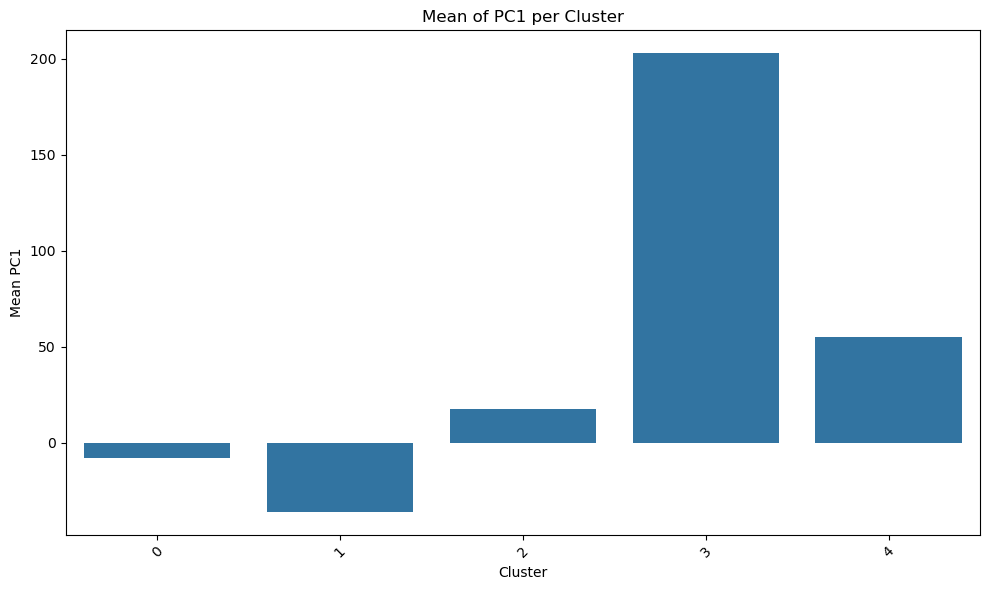

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for barplot

# Specify the column you want to analyze
column_name = 'PC1'

# Group by clusters and calculate the mean for the specified column
cluster_means = plot_df.groupby('k-means')[column_name].mean()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_means.index, y=cluster_means.values)

# Customize the plot
plt.title(f'Mean of {column_name} per Cluster')
plt.xlabel('Cluster')
plt.ylabel(f'Mean {column_name}')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot (since plt.show() may not work in this environment)
#plt.savefig('pc1_cluster_means.png')

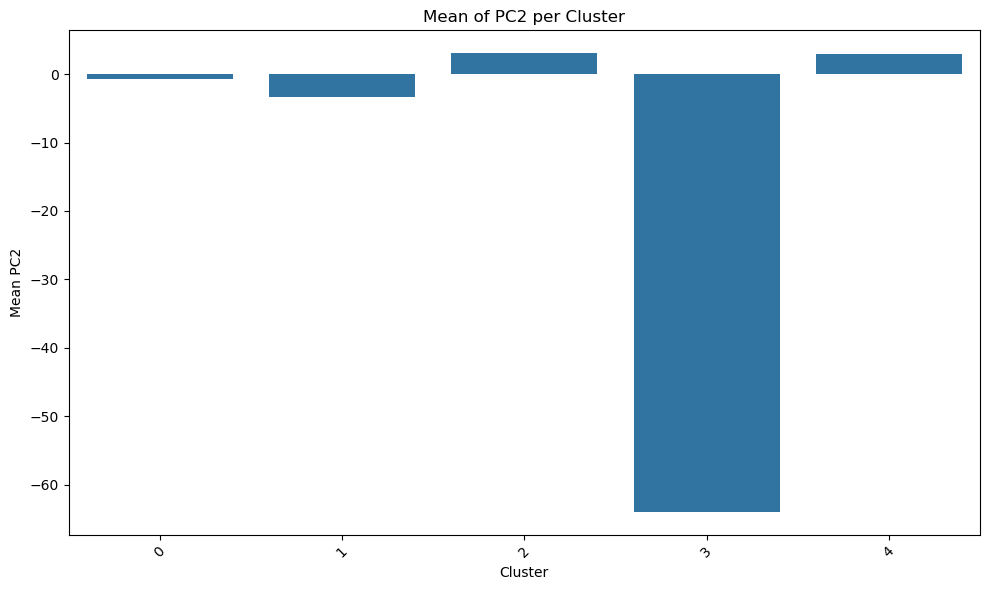

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for barplot

# Specify the column you want to analyze
column_name = 'PC2'

# Group by clusters and calculate the mean for the specified column
cluster_means = plot_df.groupby('k-means')[column_name].mean()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_means.index, y=cluster_means.values)

# Customize the plot
plt.title(f'Mean of {column_name} per Cluster')
plt.xlabel('Cluster')
plt.ylabel(f'Mean {column_name}')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot (since plt.show() may not work in this environment)
#plt.savefig('pc1_cluster_means.png')

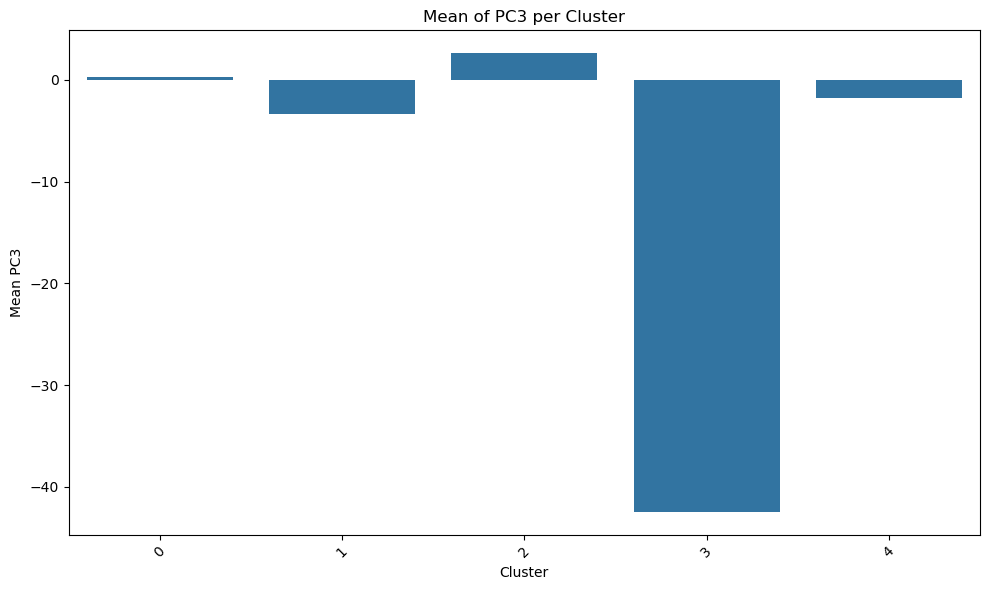

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for barplot

# Specify the column you want to analyze
column_name = 'PC3'

# Group by clusters and calculate the mean for the specified column
cluster_means = plot_df.groupby('k-means')[column_name].mean()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_means.index, y=cluster_means.values)

# Customize the plot
plt.title(f'Mean of {column_name} per Cluster')
plt.xlabel('Cluster')
plt.ylabel(f'Mean {column_name}')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot (since plt.show() may not work in this environment)
#plt.savefig('pc1_cluster_means.png')

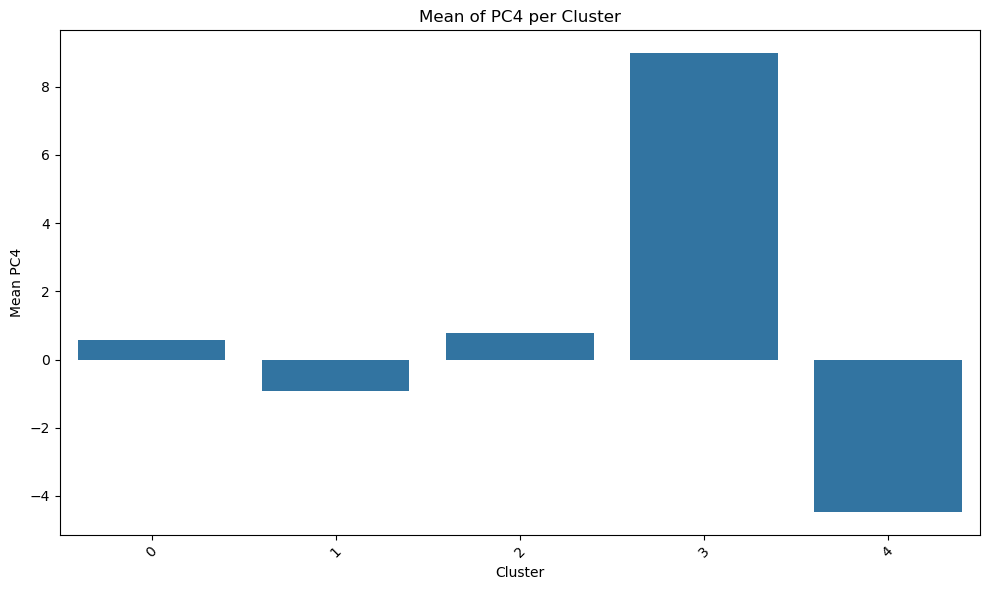

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for barplot

# Specify the column you want to analyze
column_name = 'PC4'

# Group by clusters and calculate the mean for the specified column
cluster_means = plot_df.groupby('k-means')[column_name].mean()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_means.index, y=cluster_means.values)

# Customize the plot
plt.title(f'Mean of {column_name} per Cluster')
plt.xlabel('Cluster')
plt.ylabel(f'Mean {column_name}')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot (since plt.show() may not work in this environment)
#plt.savefig('pc1_cluster_means.png')

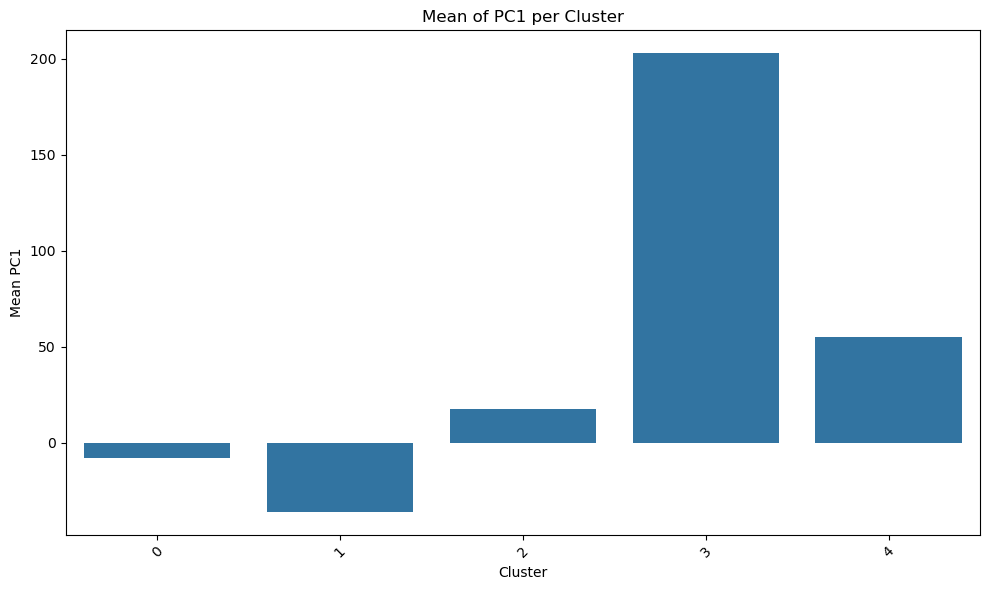

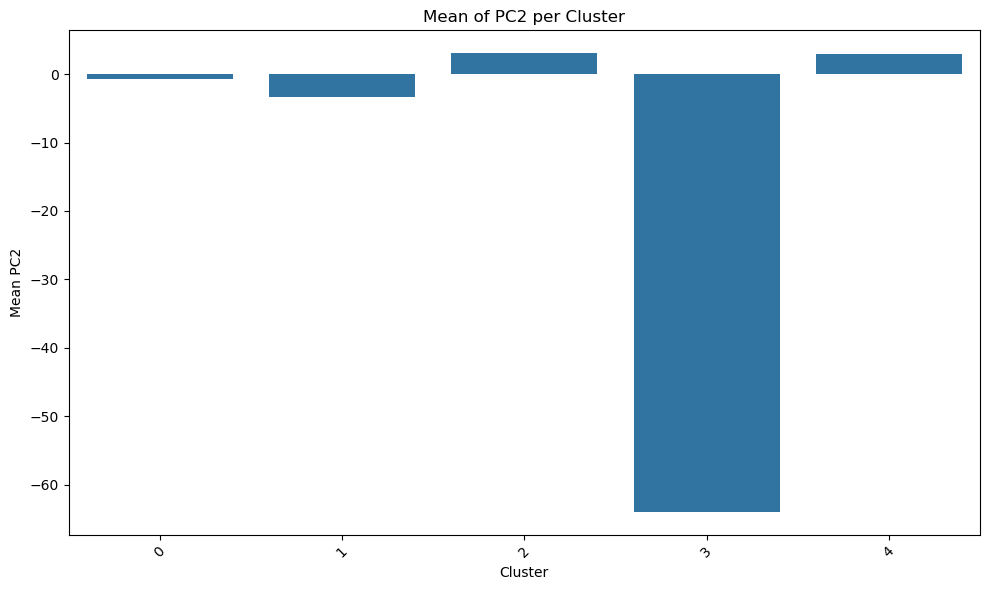

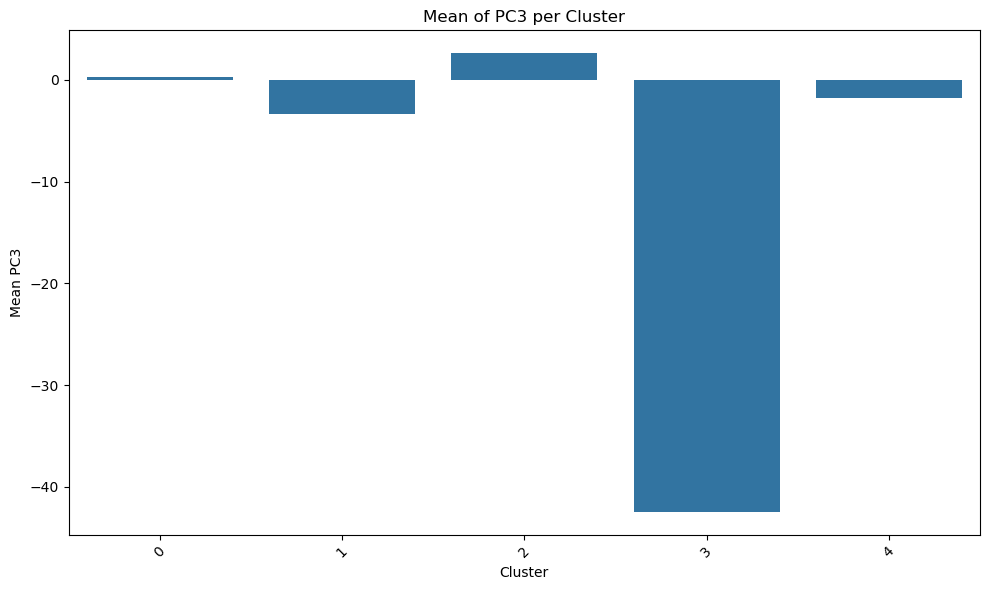

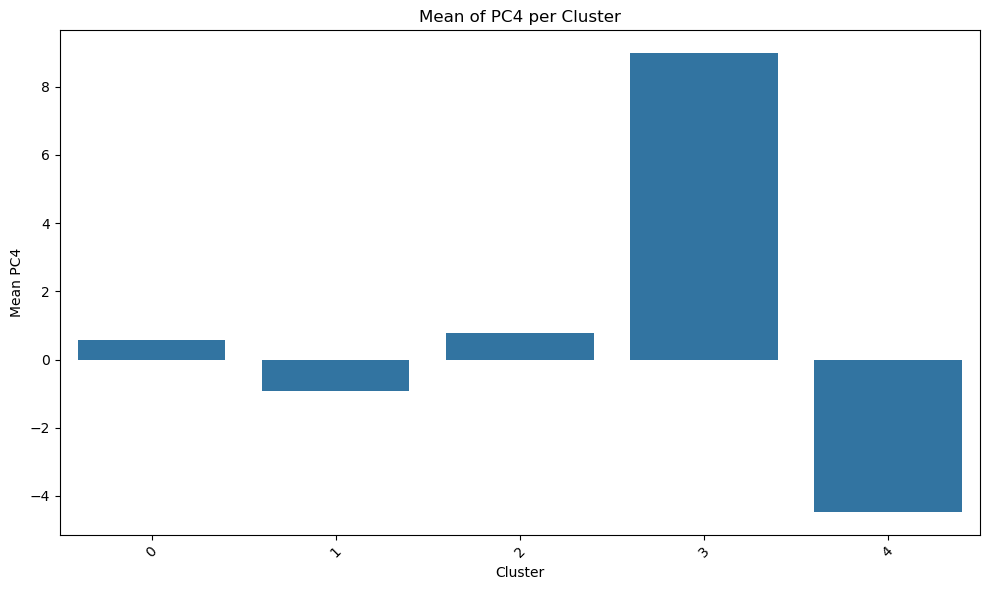

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Loop through each PCA component (PC1 to PC20)
for i in range(1, 5):
    column_name = f'PC{i}'
    
    # Group by clusters and calculate the mean for the current PC
    cluster_means = plot_df.groupby('k-means')[column_name].mean()
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_means.index, y=cluster_means.values)
    
    # Customize the plot
    plt.title(f'Mean of {column_name} per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {column_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to a file
    plt.savefig(f'mean_{column_name}.png')
    #plt.close()  # Close the figure to free memory

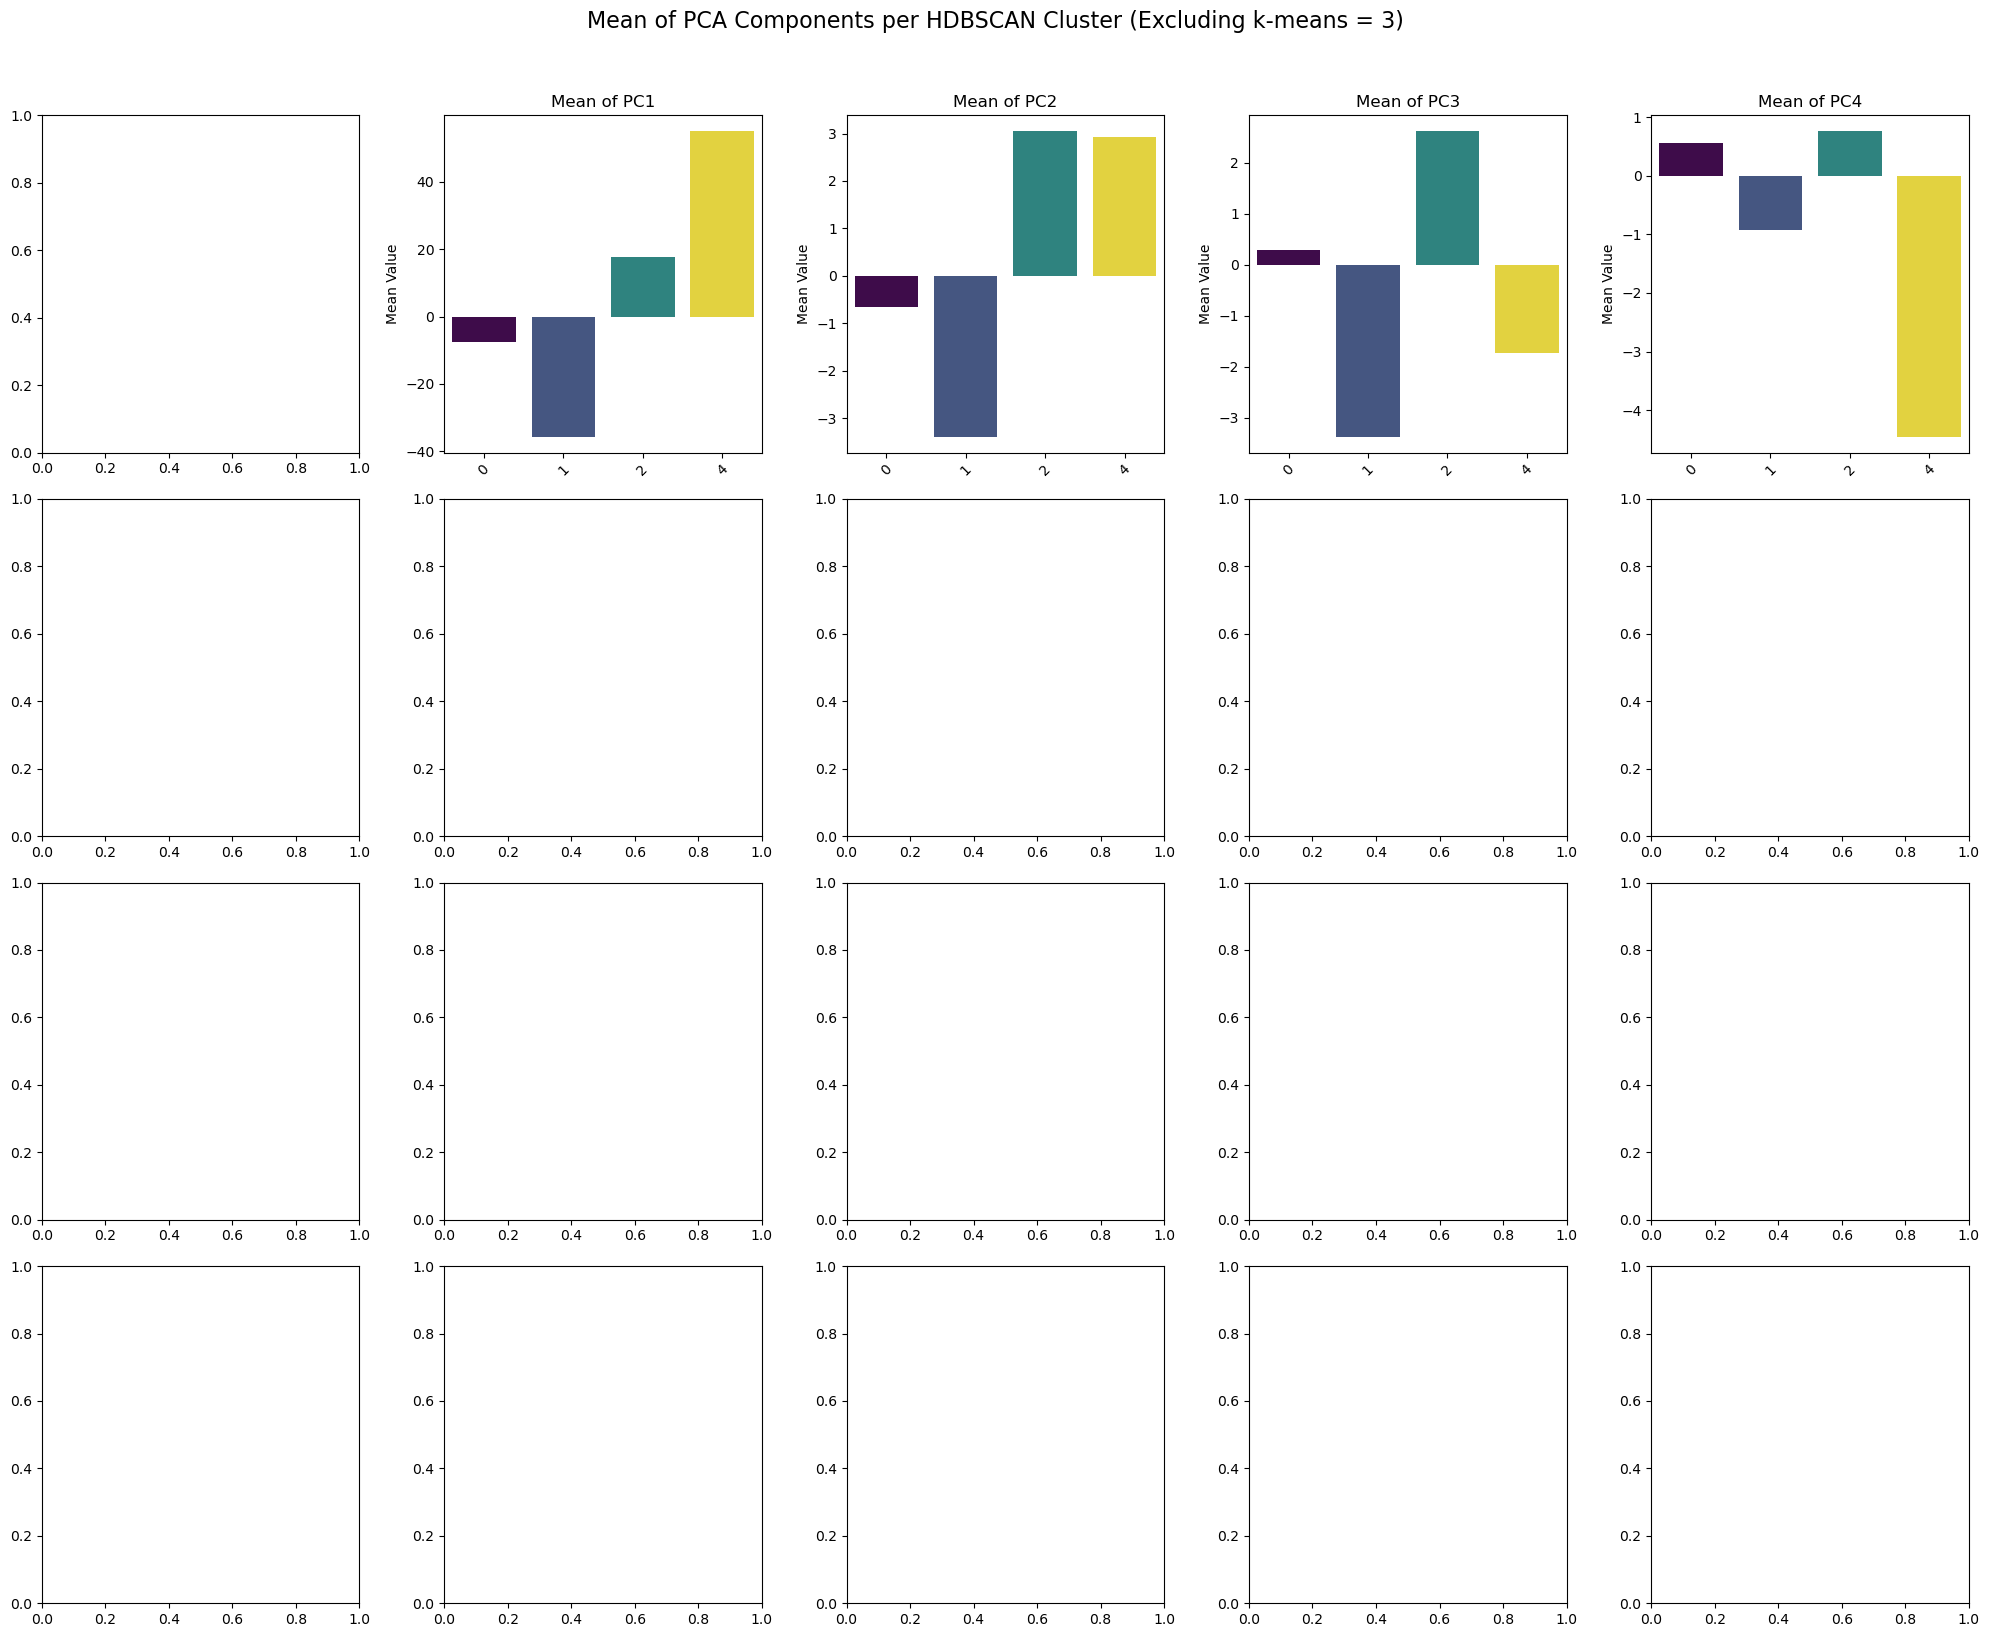

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a 4x5 grid of subplots in one figure
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier iteration

# Loop through each PCA component (PC1 to PC20)
for i in range(1, 5):
    column_name = f'PC{i}'
    # Group by clusters, filter out k-means == 3, and calculate the mean for the current PC
    cluster_means = plot_df[plot_df['k-means'] != 3].groupby('k-means')[column_name].mean().reset_index()
    # Create the bar plot with hue assigned to x and no legend
    sns.barplot(x='k-means', y=column_name, hue='k-means', data=cluster_means, 
                palette='viridis', legend=False, ax=axes[i])
    # Customize the subplot
    axes[i].set_title(f'Mean of {column_name}')
    if i >= 15:  # X-label only on bottom row
        axes[i].set_xlabel('Cluster')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Mean Value')
    axes[i].tick_params(axis='x', rotation=45)

# Add a super title and adjust layout
plt.suptitle('Mean of PCA Components per HDBSCAN Cluster (Excluding k-means = 3)', y=1.02, fontsize=16)
plt.tight_layout()

# Save the figure
plt.savefig('pca_mean_barplots_4x5_excl_kmeans3.png', bbox_inches='tight')

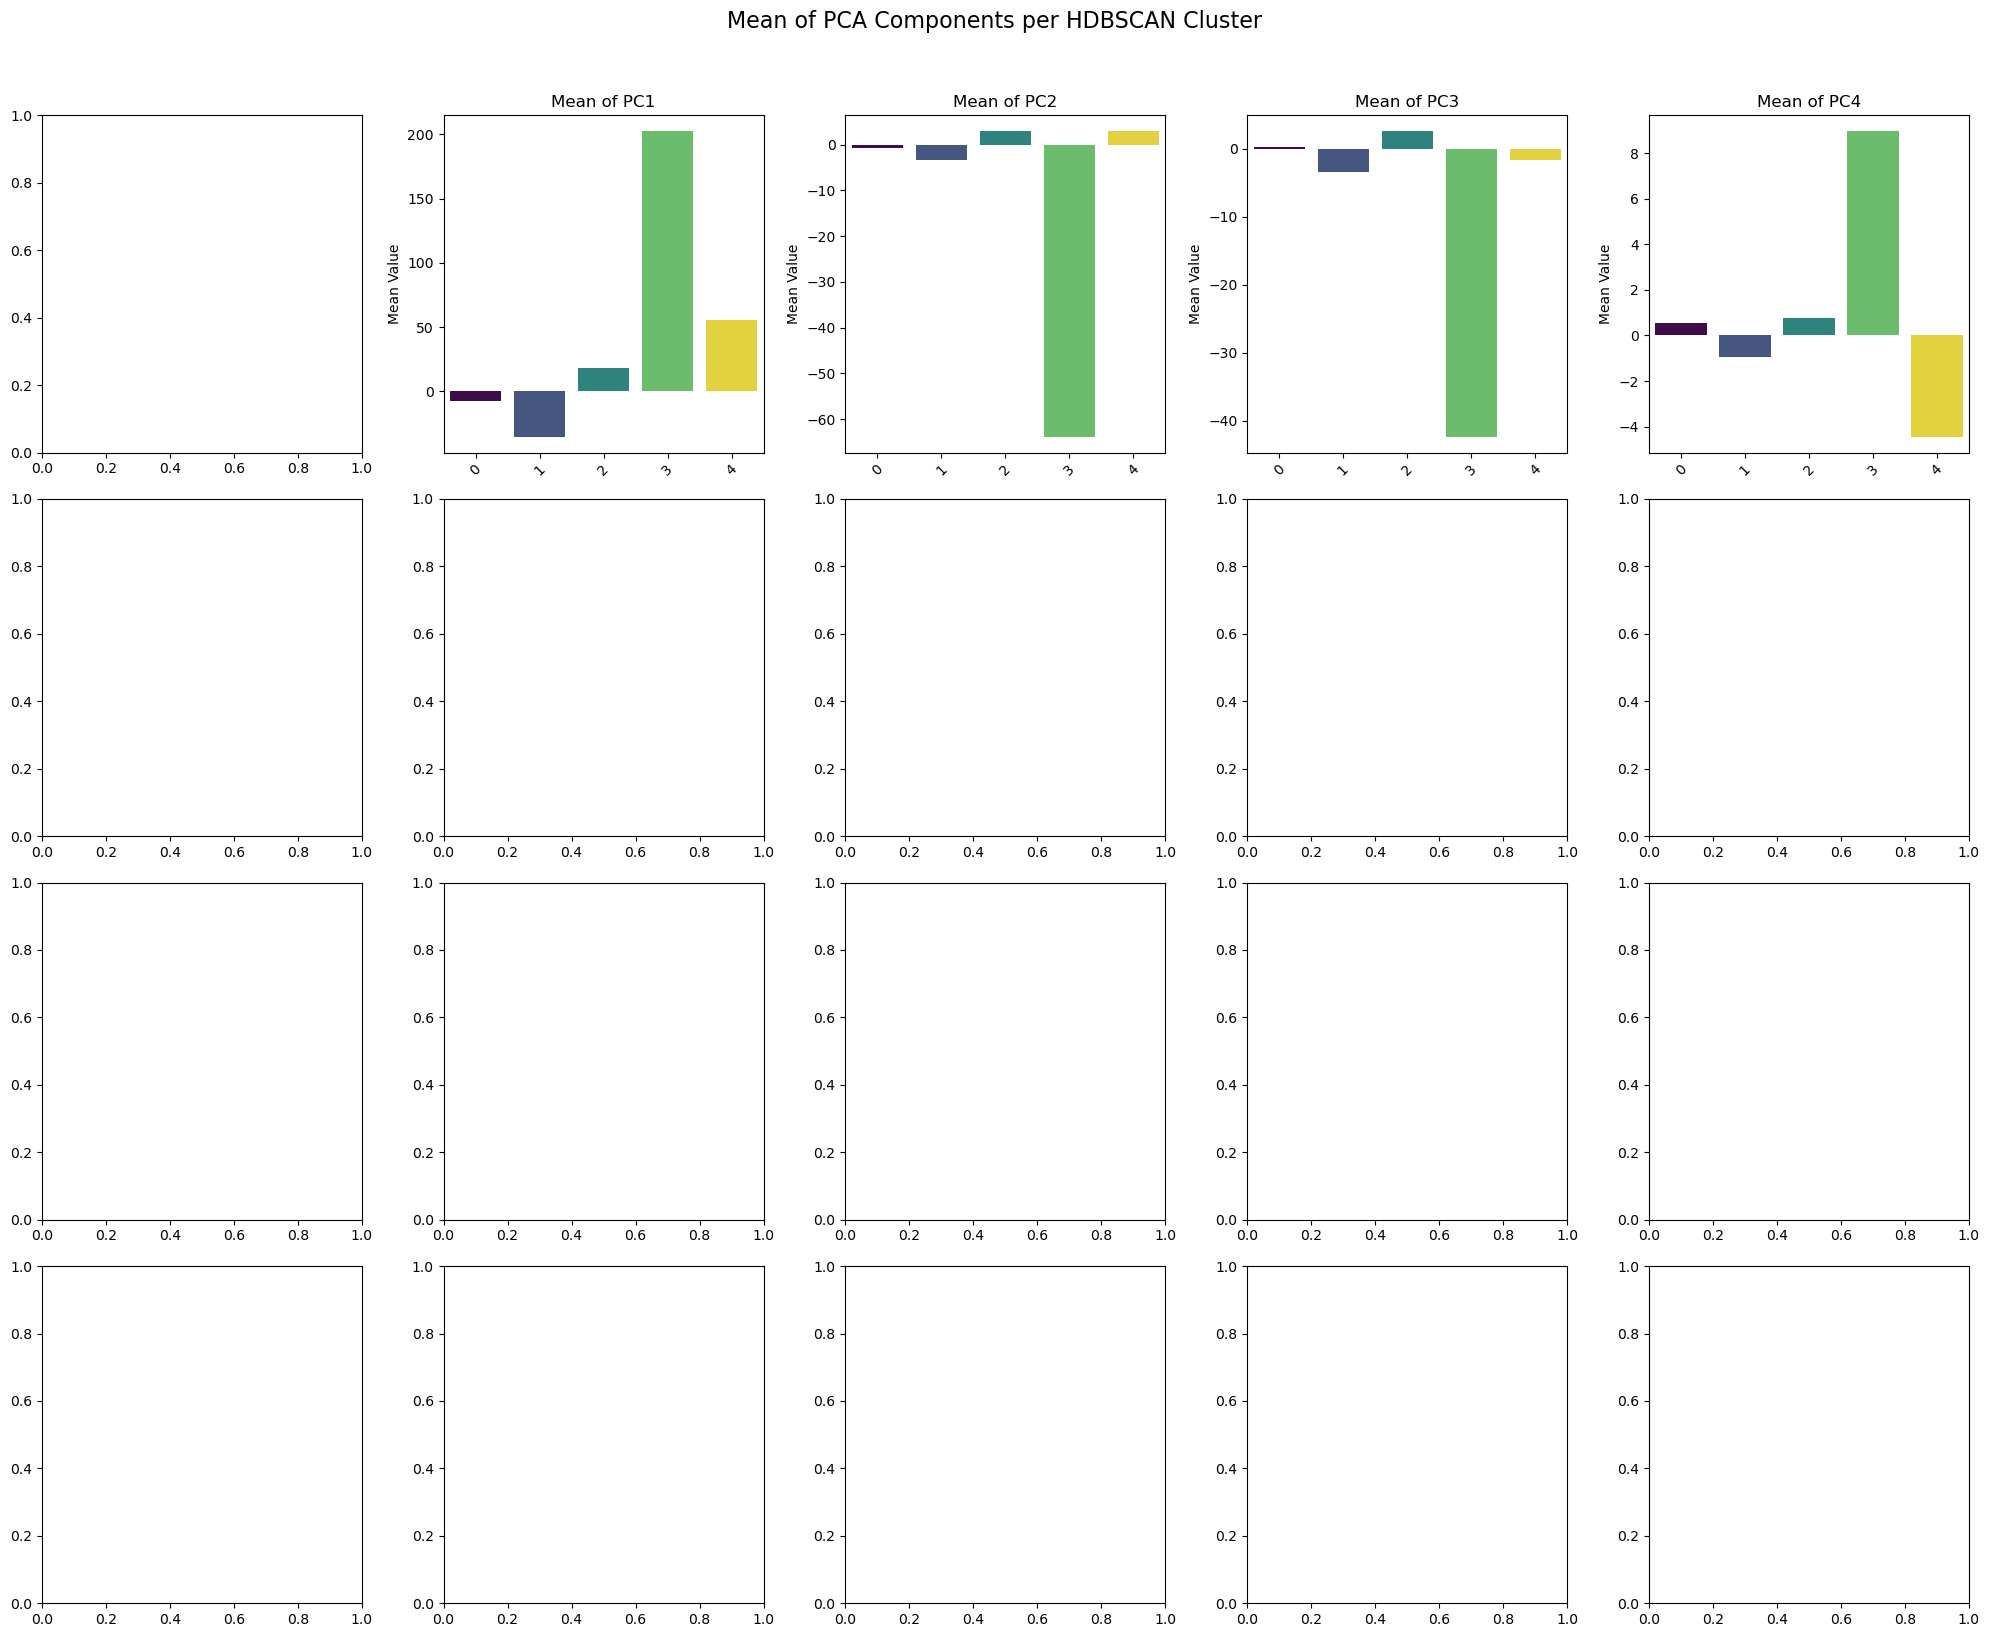

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a 4x5 grid of subplots in one figure
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier iteration

# Loop through each PCA component (PC1 to PC20)
for i in range(1, 5):
    column_name = f'PC{i}'
    # Group by clusters and calculate the mean for the current PC
    cluster_means = plot_df.groupby('k-means')[column_name].mean().reset_index()
    # Create the bar plot with hue assigned to x and no legend
    sns.barplot(x='k-means', y=column_name, hue='k-means', data=cluster_means, 
                palette='viridis', legend=False, ax=axes[i])
    # Customize the subplot
    axes[i].set_title(f'Mean of {column_name}')
    if i >= 15:  # X-label only on bottom row
        axes[i].set_xlabel('Cluster')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Mean Value')
    axes[i].tick_params(axis='x', rotation=45)

# Add a super title and adjust layout
plt.suptitle('Mean of PCA Components per HDBSCAN Cluster', y=1.02, fontsize=16)
plt.tight_layout()

# Save the figure
plt.savefig('pca_mean_barplots_4x5.png', bbox_inches='tight')

## TODO: 
- extract cluster 
- check out images
- 

## Extracting Cluster images

In [31]:
import shutil

def save_cluster_images(df, cluster_name, cluster_number, output_path):
    cluster = df[df[cluster_name] == cluster_number]
    images = cluster.image_path.tolist()
    #images = random.sample(images, k=n_imgs)
    os.makedirs(output_path, exist_ok=True)
    for img in images:
        basename = os.path.basename(img)
        dst_file = os.path.join(output_path, basename)
        shutil.copy2(img, dst_file)  

Inspect localy:

``
scp vsc35907@login.hpc.kuleuven.be:/scratch/leuven/359/vsc35907/feature_extraction_data/analysis/k_means4/0/* /Users/theo/Desktop/4th_semester/THESIS/data_analysis/k_means4/0/
``

### K Means Clusters

In [32]:
directory = '/scratch/leuven/359/vsc35907/feature_extraction_data/analysis/k_means4'

clusters = [0,1,2,3,4]

for c in clusters:
    output_path = os.path.join(directory, str(c))
    save_cluster_images(df, 'k-means', c, output_path)
    print(f'Cluster {c} size: {len(os.listdir(output_path))}')

Cluster 0 size: 919
Cluster 1 size: 446
Cluster 2 size: 708
Cluster 3 size: 8
Cluster 4 size: 160


### HDBSCAN

In [76]:
directory = '/scratch/leuven/359/vsc35907/feature_extraction_data/analysis/hdbscan'

clusters = [0]

for c in clusters:
    output_path = os.path.join(directory, str(c))
    save_cluster_images(df, 'HDBSCAN', c, output_path)
    print(f'Cluster {c} size: {len(os.listdir(output_path))}')

Cluster 0 size: 92


#### TSNE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from adjustText import adjust_text  # Auto-adjust text to prevent overlap
from sklearn.preprocessing import StandardScaler

# Step 1: Compute a single feature vector per group (mean aggregation)
group_names = list(loaded_control_data.keys())
group_features = np.array([loaded_control_data[group].mean(dim=0).cpu().numpy() for group in group_names])

scaler = StandardScaler()
group_features = scaler.fit_transform(group_features)

# Step 2: Apply Dimensionality Reduction (PCA or t-SNE)
dim_reduction = "TSNE"  # Choose "PCA" or "TSNE"

if dim_reduction == "PCA":
    reducer = PCA(n_components=2)
elif dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)

reduced_features = reducer.fit_transform(group_features)

# Step 3: Scatter Plot
plt.figure(figsize=(36, 24))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7, edgecolors='k')

# Create list of text labels to adjust
texts = []
for i, label in enumerate(group_names):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8))

# Auto-adjust text to avoid overlapping
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"{dim_reduction} Projection of 109 Groups (1280 Features → 2D)")
plt.grid(False)

# in case you want to save the plot, change the name as well
# plt.savefig("tSNE_visualization_control.png", dpi=300, bbox_inches="tight")
plt.show()

#### PCA

In [ ]:
# Step 2: Apply Dimensionality Reduction (PCA or t-SNE)
dim_reduction = "PCA"  # Choose "PCA" or "TSNE"

if dim_reduction == "PCA":
    reducer = PCA(n_components=2)
elif dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)

reduced_features = reducer.fit_transform(group_features)

# Step 3: Scatter Plot
plt.figure(figsize=(36, 24))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7, edgecolors='k')

# Create list of text labels to adjust
texts = []
for i, label in enumerate(group_names):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8))

# Auto-adjust text to avoid overlapping
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"{dim_reduction} Projection of 109 Groups (1280 Features → 2D)")
plt.grid(False)

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
plt.show()

### Control groups combine with mutant groups

#### PCA

In [ ]:
# Step 1: Compute a single feature vector per group (mean aggregation) for both datasets
group_names_control = list(loaded_control_data.keys())
group_features_control = np.array([loaded_control_data[group].mean(dim=0).cpu().numpy() for group in group_names_control])

group_names_mutants = list(loaded_data.keys())
group_features_mutants = np.array([loaded_data[group].mean(dim=0).cpu().numpy() for group in group_names_mutants])

# Combine the two datasets for dimensionality reduction
combined_group_features = np.vstack((group_features_control, group_features_mutants))
combined_group_features = scaler.fit_transform(combined_group_features)
reduced_features = reducer.fit_transform(combined_group_features)

# Step 2: Apply Dimensionality Reduction (PCA, t-SNE, or UMAP)
dim_reduction = "PCA"  # Choose between "PCA", "TSNE", or "UMAP"

if dim_reduction == "PCA":
    reducer = PCA(n_components=2)
elif dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif dim_reduction == "UMAP":
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.3)

# Perform dimensionality reduction
reduced_features = reducer.fit_transform(combined_group_features)

# Step 3: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"{dim_reduction} Projection of Control and Mutant Groups (1280 Features → 2D)")
plt.grid(True)

# Add legend
plt.legend()

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

#### TSNE

In [ ]:
# Step 2: Apply Dimensionality Reduction (PCA, t-SNE, or UMAP)
dim_reduction = "TSNE"  # Choose between "PCA", "TSNE", or "UMAP"

if dim_reduction == "PCA":
    reducer = PCA(n_components=2)
elif dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif dim_reduction == "UMAP":
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.3)

# Perform dimensionality reduction
reduced_features = reducer.fit_transform(combined_group_features)

# Step 3: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"{dim_reduction} Projection of Control and Mutant Groups (1280 Features → 2D)")
plt.grid(True)

# Add legend
plt.legend()

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

#### UMAP

In [ ]:
# Step 2: Apply Dimensionality Reduction (PCA, t-SNE, or UMAP)
dim_reduction = "UMAP"  # Choose between "PCA", "TSNE", or "UMAP"

if dim_reduction == "PCA":
    reducer = PCA(n_components=2)
elif dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif dim_reduction == "UMAP":
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.3)

# Perform dimensionality reduction
reduced_features = reducer.fit_transform(combined_group_features)

# Step 3: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"{dim_reduction} Projection of Control and Mutant Groups (1280 Features → 2D)")
plt.grid(True)

# Add legend
plt.legend()

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

#### a more decent way: first PCA, then TSNE or UMAP

In [ ]:
# how many pca components are already enough to explain most variance
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# check pca components
pca_components = 1280  
pca = PCA(n_components=pca_components)
pca_features = pca.fit_transform(combined_group_features)
X_pca = pca_features

# Plot explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(36, 24))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Choosing the Optimal Number of PCA Components")
plt.axhline(y=0.98, color='r', linestyle='--')  # 98% threshold

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
plt.show()

# Find the number of components for 98% variance
optimal_components = np.argmax(explained_variance >= 0.98) + 1
print(f"Optimal PCA components for 98% variance: {optimal_components}")

#### PCA, then TSNE

In [ ]:
# Step 2: First Reduce Dimensionality Using PCA (e.g., from 1280 → 50)
pca_components = 51  # Reduce to 51 components before applying t-SNE/UMAP
pca = PCA(n_components=pca_components)
pca_features = pca.fit_transform(combined_group_features)

# Step 3: Further Reduce Using t-SNE or UMAP
dim_reduction = "TSNE"  # Choose between "TSNE" or "UMAP"

if dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif dim_reduction == "UMAP":
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)

# Apply t-SNE or UMAP on PCA-reduced data
reduced_features = reducer.fit_transform(pca_features)

# Step 4: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"PCA → {dim_reduction} Projection of Control and Mutant Groups (43 PCA components → 2D)")
plt.grid(False)

# Add legend
plt.legend()

# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

#### PCA, then UMAP

In [ ]:
# Step 2: First Reduce Dimensionality Using PCA (e.g., from 1280 → 50)
pca_components = 51  # Reduce to 43 components before applying t-SNE/UMAP
pca = PCA(n_components=pca_components)
pca_features = pca.fit_transform(combined_group_features)

# Step 3: Further Reduce Using t-SNE or UMAP
dim_reduction = "UMAP" # Choose between "TSNE" or "UMAP"

if dim_reduction == "TSNE":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif dim_reduction == "UMAP":
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=0.3)

# Apply t-SNE or UMAP on PCA-reduced data
reduced_features = reducer.fit_transform(pca_features)

# Step 4: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"PCA → {dim_reduction} Projection of Control and Mutant Groups (43 PCA components → 2D)")
plt.grid(False)

# Add legend
plt.legend()
# in case you want to save the plot, change the name as well
# plt.savefig("PCA_visualization_control.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

#### PCA, then UMAP with constraint

In [ ]:
# Step 2: First Reduce Dimensionality Using PCA (e.g., from 1280 → 50)
pca_components = 51  # Reduce to 50 components before applying t-SNE/UMAP
pca = PCA(n_components=pca_components)
pca_features = pca.fit_transform(combined_group_features)

# Step 3: Further Reduce Using t-SNE or UMAP
dim_reduction = "UMAP"  # Choose between "TSNE" or "UMAP"
labels = np.array([0] * len(group_features_control) + [1] * len(group_features_mutants))

umap_reducer = umap.UMAP(
    n_neighbors=100, min_dist=0.5, metric="euclidean", target_metric="categorical"
)

reduced_features = umap_reducer.fit_transform(np.vstack([group_features_control, group_features_mutants]), labels)

# Step 4: Scatter Plot with Two Colors
plt.figure(figsize=(36, 24))

# Plot points for `loaded_control_data` (blue) and `loaded_data` (red)
plt.scatter(reduced_features[:len(group_features_control), 0], reduced_features[:len(group_features_control), 1], 
            alpha=0.7, edgecolors='k', color='blue', label='Control Groups')

plt.scatter(reduced_features[len(group_features_control):, 0], reduced_features[len(group_features_control):, 1], 
            alpha=0.7, edgecolors='k', color='red', label='Mutant Groups')

# Create list of text labels to adjust for each dataset
texts = []
for i, label in enumerate(group_names_control):
    texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], label, fontsize=8, alpha=0.8, color='blue'))

for i, label in enumerate(group_names_mutants):
    texts.append(plt.text(reduced_features[len(group_features_control) + i, 0], 
                          reduced_features[len(group_features_control) + i, 1], 
                          label, fontsize=8, alpha=0.8, color='red'))

# Auto-adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add labels, title, and grid
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"PCA → {dim_reduction} Projection of Control and Mutant Groups (1280 Features → 2D)")
plt.grid(False)

# Add legend
plt.legend()
plt.savefig("PCA_then_UMAP_with_constraint.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

### Parametric analysis

In [ ]:
# downsample the control samples to get a balanced control for parametric analysis


# Stratified sampling from control groups
num_control_groups = 109
samples_per_group = 67158 // num_control_groups // num_control_groups  # How many samples per group?

downsampled_control = []
for group in loaded_control_data.keys():
    group_data = loaded_control_data[group]  # Shape (num_samples_in_group, 1280)
    
    # If a group has fewer than required samples, sample with replacement
    replace = len(group_data) < samples_per_group
    
    sampled_indices = np.random.choice(len(group_data), size=samples_per_group, replace=replace)
    downsampled_control.append(group_data[sampled_indices].cpu().numpy())

# Combine sampled control data into one array
control_stat = np.vstack(downsampled_control)

#### look at normal distribution features only, and do welch t test

In [ ]:
# Store normally distributed feature indices
normal_features = []

alpha = 0.01  # Significance level
# control_stat = control_stat.cpu().numpy()

for i in range(control_stat.shape[1]):  # Iterate over 1280 features
    feature_values = control_stat[:, i]  # Extract one feature across all samples
    
    # Normalize feature values to mean=0, std=1 for K-S test
    standardized_feature = (feature_values - np.mean(feature_values)) / np.std(feature_values)
    
    # Perform Kolmogorov-Smirnov test against normal distribution
    stat, p_value = stats.kstest(standardized_feature, 'norm')
    
    if p_value > alpha:  # p-value > 0.05 means normally distributed
        normal_features.append(i)

print(f"Number of normally distributed features: {len(normal_features)}")
print(f"Indices of normal features: {normal_features}")

# Extract normally distributed features
normal_data = control_stat[:, normal_features]
print(f"Shape after filtering: {normal_data.shape}")

In [ ]:
'''
loop over all the control strains and do the Welch’s t-test with control, with only features with normal distribution
use bonferroni correction or Multiple comparisons correction (FDR) for multitest problem
'''
welch_ttest_result = []
thred = 0.000001

for strain_name in tqdm(loaded_data.keys()):
    strain = loaded_data[strain_name]
    stat, pvalues = stats.ttest_ind(control_stat[:, normal_features], strain[:, normal_features].cpu(), axis=0, equal_var=False)
    # bonferroni correction
    pvalues_bonferroni_correction = pvalues*(len(loaded_data.keys()))
    
    # Multiple comparisons correction (FDR)
    _, fdr_corrected_pvals, _, _ = multipletests(pvalues, method='fdr_bh')
    
    num_p_under_thred = np.sum(pvalues < thred)
    bonferroni_correctionnum_p_under_thred = np.sum(pvalues_bonferroni_correction < thred)
    dfr_correction_num_p_under_thred = np.sum(fdr_corrected_pvals < thred)
    
    welch_ttest_result.append({'Gene Name': strain_name, 'Number of features with p value smaller than ' + str(thred): num_p_under_thred, 'bonferroni corrected Number of features with p value smaller than ' + str(thred): bonferroni_correctionnum_p_under_thred, 'fdr corrected Number of features with p value smaller than ' + str(thred): dfr_correction_num_p_under_thred})

# Convert the list to a DataFrame
df_welch_ttest_result = pd.DataFrame(welch_ttest_result)

# Write the DataFrame to an Excel file, replace it with your own folder
output_file = 'only_normal_corrected_224_control_less_regular_more_augmentation_welch_ttest_result.xlsx'
df_welch_ttest_result.to_excel(output_file, index=False)

#### look at all features, and do mannwhitneyu test

In [ ]:
# loop over all the mutant strains and do the Welch’s t-test with control
mannwhitneyu_result = []
thred = 0.000001

for strain_name in tqdm(loaded_data.keys()):
    strain = loaded_data[strain_name]
    stat, p = stats.mannwhitneyu(control_stat, strain.cpu(), axis=0, alternative='two-sided')

    # bonferroni correction
    p = p*1280
    num_p_under_thred = np.sum(p < thred)

    mannwhitneyu_result.append({'Gene Name': strain_name, 'Number of features with p value smaller than ' + str(thred): num_p_under_thred})

# Convert the list to a DataFrame
mannwhitneyu_result = pd.DataFrame(mannwhitneyu_result)

# Write the DataFrame to an Excel file
output_file = 'downsampled_corrected_224_less_regular_more_augmentation_mannwhitneyu_result.xlsx'
mannwhitneyu_result.to_excel(output_file, index=False)

## 3.Grad-CAM visualization examples

In [ ]:
# Utility function to find the last convolutional layer in the model
def find_last_conv_layer(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv_layer = module
    return last_conv_layer

In [ ]:
TEST_PATH = 'E:/Jiaan/processed_patches' # replace it with your own path

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

test_set_vis = get_test_loader(TEST_PATH, pretrained = True) 
image, label = next(iter(test_set_vis))

target_layers = find_last_conv_layer(model3) # Last convolutional layer of the EfficientNet

input_tensor = image
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model3, target_layers=[target_layers])

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
image_np = np.array(image)
image_np = image_np.transpose(0, 2, 3, 1)
visualization = show_cam_on_image(image_np/np.max(image_np), grayscale_cam, use_rgb=False)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

In [ ]:
from IPython.display import display

# Assuming you have an array of shape (66, 64, 64, 3)
images = visualization

# Number of images
num_images = images.shape[0]

# Determine the grid size
# grid_size = int(np.ceil(np.sqrt(num_images)))
grid_size = 3

# Image dimensions
img_height, img_width = images.shape[1:3]

# Create a new blank image with white background
grid_img = Image.new('RGB', (grid_size * img_width, grid_size * img_height), color=(255, 255, 255))

# Paste each image into the grid
for i in range(num_images):
    row = i // grid_size
    col = i % grid_size
    img = Image.fromarray(images[i])
    grid_img.paste(img, (col * img_width, row * img_height))

# Display the combined image
display(grid_img)